<a href="https://colab.research.google.com/github/Rajesh2015/Stock-Market-News-Sentiment-Analysis-and-Summarization/blob/main/IP_Stock_Market_News_Sentiment_Analysis_and_Summarization_Solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Business Context

The prices of the stocks of companies listed under a global exchange are influenced by a variety of factors, with the company's financial performance, innovations and collaborations, and market sentiment being factors that play a significant role. News and media reports can rapidly affect investor perceptions and, consequently, stock prices in the highly competitive financial industry. With the sheer volume of news and opinions from a wide variety of sources, investors and financial analysts often struggle to stay updated and accurately interpret its impact on the market. As a result, investment firms need sophisticated tools to analyze market sentiment and integrate this information into their investment strategies.

## Objective

With an ever-rising number of news articles and opinions, an investment startup aims to leverage artificial intelligence to address the challenge of interpreting stock-related news and its impact on stock prices. They have collected historical daily news for a specific company listed under NASDAQ, along with data on its daily stock price and trade volumes.

As a member of the Data Science and AI team in the startup, you have been tasked with analyzing the data, developing an AI-driven sentiment analysis system that will automatically process and analyze news articles to gauge market sentiment, and summarizing the news at a weekly level to enhance the accuracy of their stock price predictions and optimize investment strategies. This will empower their financial analysts with actionable insights, leading to more informed investment decisions and improved client outcomes.

## Data Dictionary

* `Date` : The date the news was released
* `News` : The content of news articles that could potentially affect the company's stock price
* `Open` : The stock price (in \$) at the beginning of the day
* `High` : The highest stock price (in \$) reached during the day
* `Low` :  The lowest stock price (in \$) reached during the day
* `Close` : The adjusted stock price (in \$) at the end of the day
* `Volume` : The number of shares traded during the day
* `Label` : The sentiment polarity of the news content
    * 1: positive
    * 0: neutral
    * -1: negative


## Installing the necessary libraries

In [116]:
!pip install catboost

In [37]:
!pip install --upgrade --upgrade-strategy eager numpy gensim zeugma

  Using cached numpy-2.2.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)


## Importing the necessary libraries

In [38]:
# to read and manipulate the data
import pandas as pd
import numpy as np
pd.set_option('max_colwidth', None)    # setting column to the maximum column width as per the data

# to visualise data
import matplotlib.pyplot as plt
import seaborn as sns

# Deep Learning library
import torch
# to use regular expressions for manipulating text data
import re

# to load the natural language toolkit
import nltk
nltk.download('stopwords')    # loading the stopwords
nltk.download('wordnet')    # loading the wordnet module that is used in stemming
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('punkt_tab')
# to remove common stop words
from nltk.corpus import stopwords


# to perform stemming
from nltk.stem.porter import PorterStemmer
# lemmatiser
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
# to create Bag of Words
from sklearn.feature_extraction.text import CountVectorizer

# to import Word2Vec
from gensim.models import Word2Vec

# to split data into train and test sets
from sklearn.model_selection import train_test_split

# to build a Random Forest model
from sklearn.ensemble import RandomForestClassifier

# to compute metrics to evaluate the model
from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix

# To tune different models
from sklearn.model_selection import GridSearchCV
import kagglehub
from gensim.models import KeyedVectors
from nltk.stem import WordNetLemmatizer
from gensim.scripts.glove2word2vec import glove2word2vec
from sentence_transformers import SentenceTransformer


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


# All functions which is used multiple times are defined under Utils block  

###  Styling

In [39]:
#  store pellete for future use
pellete='Set2'
colors = sns.color_palette(pellete)  # Get Set2 color palette for future use
sns.set(style="darkgrid") # Set grid style

## Loading the dataset

In [40]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [41]:
# loading data into a pandas dataframe
stocks_news = pd.read_csv("/content/drive/MyDrive/Python Course_shared/NLP/stock_news.csv")

In [42]:
# creating a copy of the data
data = stocks_news.copy()

## Data Overview

In [43]:
# Show how the data looks like on fileds level
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 349 entries, 0 to 348
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    349 non-null    object 
 1   News    349 non-null    object 
 2   Open    349 non-null    float64
 3   High    349 non-null    float64
 4   Low     349 non-null    float64
 5   Close   349 non-null    float64
 6   Volume  349 non-null    int64  
 7   Label   349 non-null    int64  
dtypes: float64(4), int64(2), object(2)
memory usage: 21.9+ KB


### Observations:
There are around 8 coulmns
- There are 2 object datatypes.
- There are 4 float64 datatypes.
- There are 2 int64 datatypes.


---
Date seems to be of object type which we should consider converting as date


In [44]:
# dataframe shape
data.shape

(349, 8)

### Observations:
349 data points in dataset

### Checking the first five rows of the data

In [45]:
# Show first 5 records
data.head(5)

,Date,News,Open,High,Low,Close,Volume,Label
0,2019-01-02,"The tech sector experienced a significant decline in the aftermarket following Apple's Q1 revenue warning. Notable suppliers, including Skyworks, Broadcom, Lumentum, Qorvo, and TSMC, saw their stocks drop in response to Apple's downward revision of its revenue expectations for the quarter, previously announced in January.",41.740002,42.244999,41.482498,40.246914,130672400,-1
1,2019-01-02,"Apple lowered its fiscal Q1 revenue guidance to $84 billion from earlier estimates of $89-$93 billion due to weaker than expected iPhone sales. The announcement caused a significant drop in Apple's stock price and negatively impacted related suppliers, leading to broader market declines for tech indices such as Nasdaq 10",41.740002,42.244999,41.482498,40.246914,130672400,-1
2,2019-01-02,"Apple cut its fiscal first quarter revenue forecast from $89-$93 billion to $84 billion due to weaker demand in China and fewer iPhone upgrades. CEO Tim Cook also mentioned constrained sales of Airpods and Macbooks. Apple's shares fell 8.5% in post market trading, while Asian suppliers like Hon",41.740002,42.244999,41.482498,40.246914,130672400,-1
3,2019-01-02,"This news article reports that yields on long-dated U.S. Treasury securities hit their lowest levels in nearly a year on January 2, 2019, due to concerns about the health of the global economy following weak economic data from China and Europe, as well as the partial U.S. government shutdown. Apple",41.740002,42.244999,41.482498,40.246914,130672400,-1
4,2019-01-02,"Apple's revenue warning led to a decline in USD JPY pair and a gain in Japanese yen, as investors sought safety in the highly liquid currency. Apple's underperformance in Q1, with forecasted revenue of $84 billion compared to analyst expectations of $91.5 billion, triggered risk aversion mood in markets",41.740002,42.244999,41.482498,40.246914,130672400,-1


### Fews stats and null value check

In [46]:
# Dataframe Stats
data.describe()

,Open,High,Low,Close,Volume,Label
count,349.000000,349.000000,349.000000,349.000000,3.490000e+02,349.000000
mean,46.229233,46.700458,45.745394,44.926317,1.289482e+08,-0.054441
std,6.442817,6.507321,6.391976,6.398338,4.317031e+07,0.715119
min,37.567501,37.817501,37.305000,36.254131,4.544800e+07,-1.000000
25%,41.740002,42.244999,41.482498,40.246914,1.032720e+08,-1.000000
50%,45.974998,46.025002,45.639999,44.596924,1.156272e+08,0.000000
75%,50.707500,50.849998,49.777500,49.110790,1.511252e+08,0.000000
max,66.817497,67.062500,65.862503,64.805229,2.444392e+08,1.000000


In [47]:
#Check null value
data.isnull().sum()

,0
Date,0
News,0
Open,0
High,0
Low,0
Close,0
Volume,0
Label,0


### Observations:
No Null values

In [48]:
data.duplicated().sum()

0

### Observations:
No Duplicate value

In [49]:
data.nunique()

,0
Date,71
News,349
Open,70
High,70
Low,71
Close,71
Volume,71
Label,3


In [50]:
data['Label'].unique()

array([-1,  0,  1])

### Observations:
- 349 distint news
- Three Labels present (-1,0,1)

## Exploratory Data Analysis (EDA)

#### Helper Utils

In [51]:
def plot_bar_chart_percentage(df, column_name, xlabel, pellete, bar_width=0.6):
    """
    Plots the percentage distribution of a specified categorical column in a DataFrame.

    Parameters:
    - df: DataFrame containing the data.
    - column_name: The name of the column to analyze.
    - colors: List of colors for the bar plot.
    - figsize: Tuple specifying the figure size.
    - bar_width: Width of the bars in the bar plot.
    """
    # Calculate the percentage of each category in the specified column
    percentages = df[column_name].value_counts(normalize=True)*100
    percentages = percentages.reset_index().rename(columns={ column_name: column_name, 'proportion': 'percent'})
    n=df[column_name].nunique()
    # Increase figure size for better readability
    plt.figure(figsize=(n+1,6))

    # Plot the bar plot with reduced bar width
    ax=sns.barplot(x=column_name, y='percent', data=percentages, palette=pellete,hue=column_name, width=bar_width)

    # Annotate the plot with the count values
    annotate_chart(plt, ax)

    # Set labels and title
    plt.ylabel('Percentage')
    plt.xlabel(xlabel)
    plt.title(f'Overview of {xlabel}')
    plt.xticks(rotation=45)

    # Show the plot
    plt.tight_layout()  # Adjust layout to prevent overlapping
    plt.legend([],[], frameon=False)
    plt.show()

In [52]:
def plot_histogram_and_boxplot(df, column, xlabel, ylabel, title):
    """
    Plots a histogram with KDE and a box plot for a specified column in a DataFrame.

    Parameters:
    df (DataFrame): The DataFrame containing the data.
    column (str): The column name for which the plots are to be drawn.
    xlabel (str): The label for the x-axis.
    ylabel (str): The label for the y-axis.
    title (str): The title for the graph.
    Returns:
    None
    """
    # Calculate percentiles
    q25 = df[column].quantile(0.25)
    q50 = df[column].quantile(0.50)
    q75 = df[column].quantile(0.75)
    mean_value = df[column].mean()
    # Create the figure and set the size
    f, (hist, box) = plt.subplots(nrows=2, sharex=True, figsize=(8, 10))

    # Create the histogram with KDE
    sns.histplot(data=df, x=column, ax=hist, kde=True, legend=True, color='lightcoral')
    hist.set_xlabel(xlabel)
    hist.axvline(mean_value, color='peru', linestyle=':', label='Mean')
    hist.axvline(q25, color='green', linestyle='--', label='25th percentile')
    hist.axvline(q50, color='blue', linestyle='-', label='50th percentile (Median)')
    hist.axvline(q75, color='purple', linestyle='--', label='75th percentile')
    hist.set_ylabel(ylabel)
    hist.legend()

    # Create the box plot in a subplot below the histogram
    sns.boxplot(data=df, x=column, ax=box, color='lightcoral')
    box.axvline(mean_value, color='peru', linestyle=':', label=f'Mean: {mean_value:.2f}')
    box.axvline(q25, color='green', linestyle='--', label=f'25th percentile: {q25:.2f}')
    box.axvline(q50, color='blue', linestyle='-', label=f'50th percentile: {q50:.2f}')
    box.axvline(q75, color='purple', linestyle='--', label=f'75th percentile: {q75:.2f}')

    # Setting the x-label and title on the shared axis and figure
    box.set_xlabel(xlabel)
    f.suptitle(title)

    # Adjust layout and show the combined plots
    f.tight_layout(rect=[0, 0, 1, 0.95])
    box.legend()  # Add legend to the box plot for the percentiles


In [53]:
def annotate_chart(plot, ax):
    """
    Annotates a chart with the height of each bar.

    Parameters:
    - plot (matplotlib.pyplot): The matplotlib plot object.
    - ax (Axes): The Axes object to annotate.
    """
    for p in ax.patches:
        height = p.get_height()

        # Only annotate if height is significant, and avoid zero or near-zero annotations
        if height > 0.001:
            plot.annotate(f'{format(height, ".1f")}% ',          # Annotate with 1 decimal places
                          (p.get_x() + p.get_width() / 2., height),  # Position the annotation at the top of the bar
                          ha='center', va='center',       # Center the annotation
                          xytext=(0, 4),                  # Small offset to avoid overlapping with the bar
                          textcoords='offset points')


In [54]:
def plot_boxplot(df, x_col, y_col, hue_col=None, title=None, xlabel=None, figsize=(8, 5), xticks_rotation=90):
    """
    Creates a box plot to visualize the relationship between variables.

    Parameters:
    - df: pandas DataFrame containing the data.
    - x_col: str, column name for the x-axis.
    - y_col: str, column name for the y-axis.
    - hue_col: str, column name for grouping by color (optional).
    - title: str, title of the plot (optional).
    - xlabel: str, label for the x-axis (optional).
    - figsize: tuple, size of the figure (default is (8, 5)).
    - xticks_rotation: int, rotation angle for x-axis tick labels (default is 90).
      Returns:
    - plt (matplotlib.pyplot): The matplotlib plot object with annotations.
    """

    plt.figure(figsize=figsize)  # Set the figure size
    bxp = sns.boxplot(data=df, x=x_col, y=y_col, hue=hue_col,palette="Set2")  # Create the box plot

    if xlabel:
        bxp.set_xlabel(xlabel)  # Set x-axis label if provided
    if title:
        bxp.axes.set_title(title)  # Set the plot title if provided

    plt.xticks(rotation=xticks_rotation)  # Rotate x-axis labels
    return plt


In [55]:
def draw_box_plot_with_legend(df, x, xlabel, color='red'):
    """
    Draws a box plot with a vertical line indicating the mean value and includes a legend.

    Parameters:
    - df (pandas.DataFrame): The DataFrame containing the data to plot.
    - x (str): The name of the column in the DataFrame to be plotted.
    - xlabel (str): The label for the x-axis.
    - color (str, optional): The color of the box plot. Default is 'red'.

    Returns:
    - plt (matplotlib.pyplot): The matplotlib pyplot object for further customization or saving.
    """
    mean_value = df[x].mean()
    sns.boxplot(data=df, x=x, color=color)
    plt.xlabel(xlabel)
    plt.axvline(mean_value, color='green', linestyle=':', label=f'Mean: {mean_value:.2f}')
    plt.legend()
    return plt

In [56]:
def plot_box_plot_side_by_side(df, x, xlabel, category_col, color='red'):
    """
    Plots side-by-side box plots for different categories in a DataFrame.

    Parameters:
    - df (pandas.DataFrame): The DataFrame containing the data to plot.
    - x (str): The name of the column in the DataFrame to be plotted.
    - xlabel (str): The label for the x-axis.
    - category_col (str): The column name in the DataFrame used to categorize the data.
    - color (str, optional): The color of the box plot. Default is 'red'.

    Returns:
    - plt (matplotlib.pyplot): The matplotlib pyplot object for further customization or saving.
    """
    # Extract unique categories
    categories = df[category_col].unique()

    # Create subplots with 1 row and the number of columns equal to the number of categories
    fig, axes = plt.subplots(1, len(categories), figsize=(12, 2))

    # Loop over each category and plot
    for i, category in enumerate(categories):
        plt.sca(axes[i])  # Set the current axes
        subset = df[df[category_col] == category]
        draw_box_plot_with_legend(subset, x, xlabel, color=color)
        axes[i].set_title(f'{category.capitalize()}')

    plt.tight_layout()
    return plt



---



### Univariate Analysis

In [57]:
data.columns

Index(['Date', 'News', 'Open', 'High', 'Low', 'Close', 'Volume', 'Label'], dtype='object')

In [58]:
# Map each of these -1,0,1 to labels like Nagative,Positive and Neutral
data['sentiment_label']=data['Label'].map({1:'Positive',0:'Neutral',-1:'Negative'})

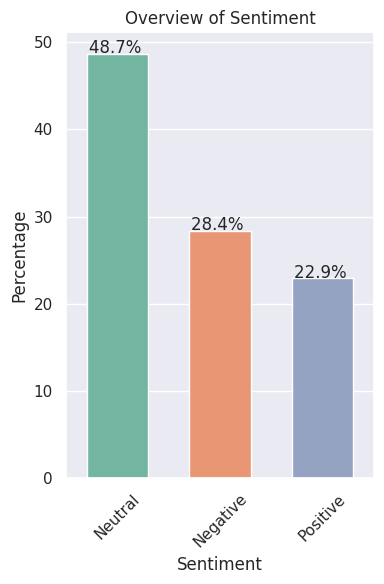

In [59]:

# Plot bar chart to check the class
plot_bar_chart_percentage(df=data,column_name='sentiment_label',xlabel='Sentiment',pellete=pellete)

### Observations:
- Around 48.7% is neutral in this dataset followed by 28.4% and postive sentiments are least 22.9%
---
While doing sentiment classification we should take this one in to account

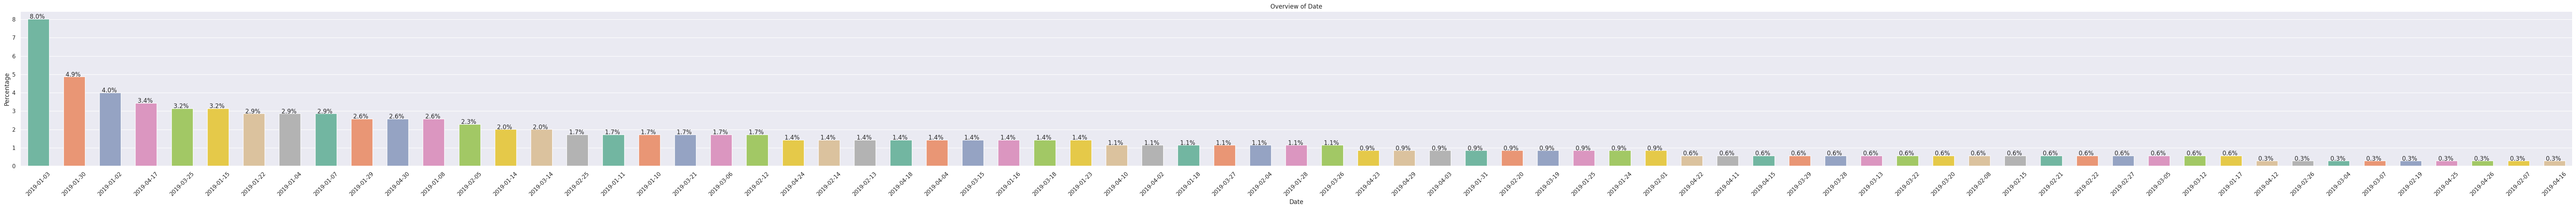

In [60]:
# Bar chart to see those data points date wise
plot_bar_chart_percentage(df=data,column_name='Date',xlabel='Date',pellete=pellete)

### Observations:
- Highest no of review from 03-01-2019 (8%) followed by 30-01-2019 (4.9%) and 02-01-2019 (4%)

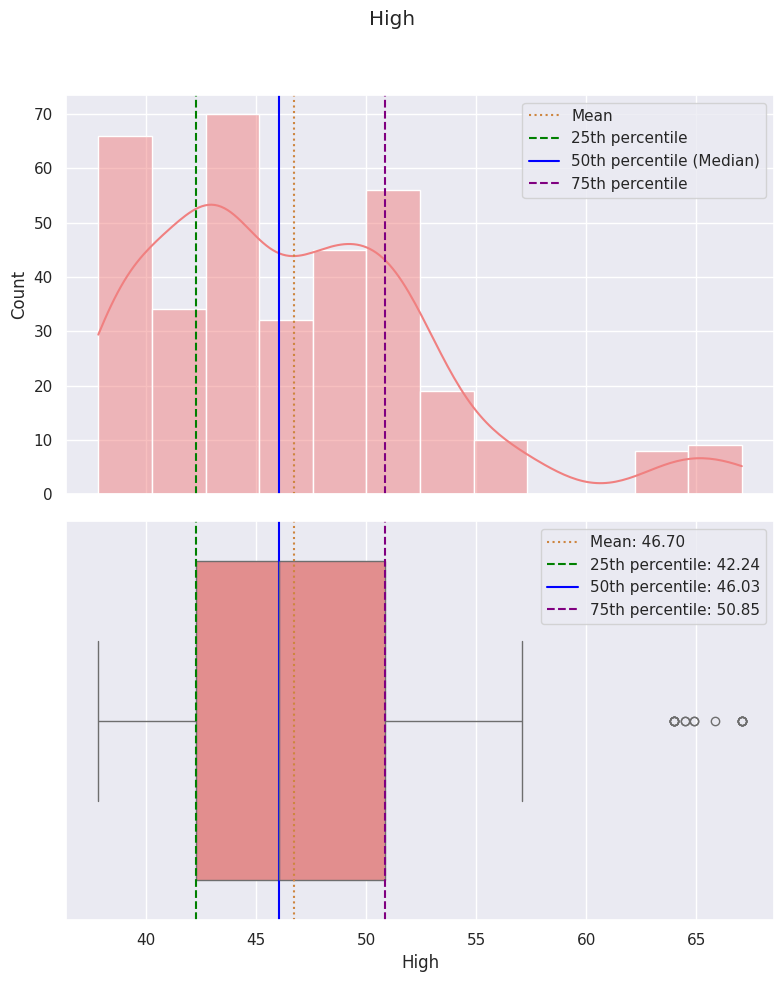

In [61]:
# Distribution of High
plot_histogram_and_boxplot(df=data,column='High',xlabel='High',ylabel='Count',title='High')

### Observations:
- We can see the distribution of Highest Stock Price is right skewed.
- The mean is at 46.7 and median is at 46.03(slight right skewed)

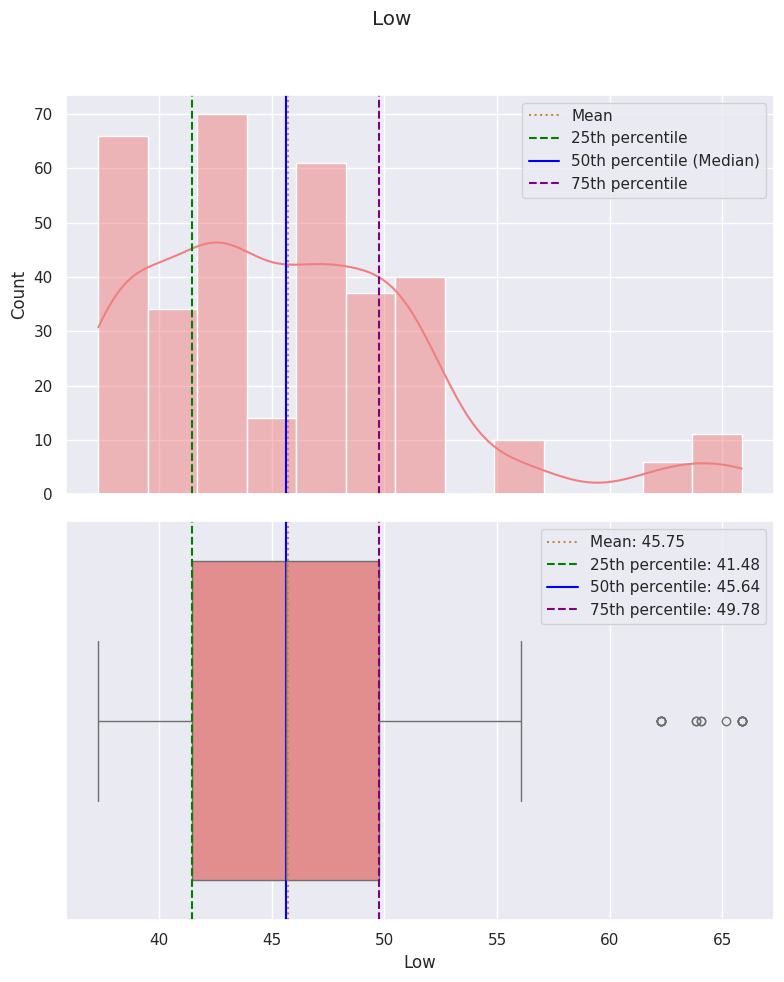

In [62]:
# DIstribution of low
plot_histogram_and_boxplot(df=data,column='Low',xlabel='Low',ylabel='Count',title='Low')

### Observations:
- Both mean and median is near to each other (45.5)

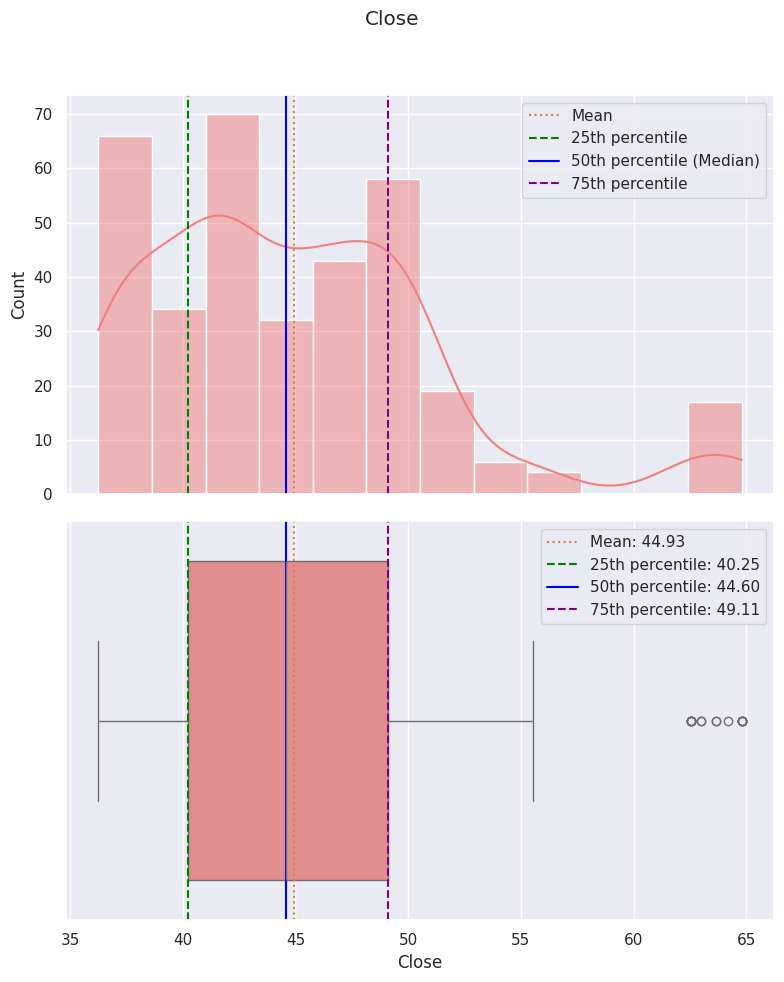

In [63]:
# Distribution of Close
plot_histogram_and_boxplot(df=data,column='Close',xlabel='Close',ylabel='Count',title='Close')

### Observations:
-  Close price is right skewed slightly with mean at 44.93 and median at 44.6

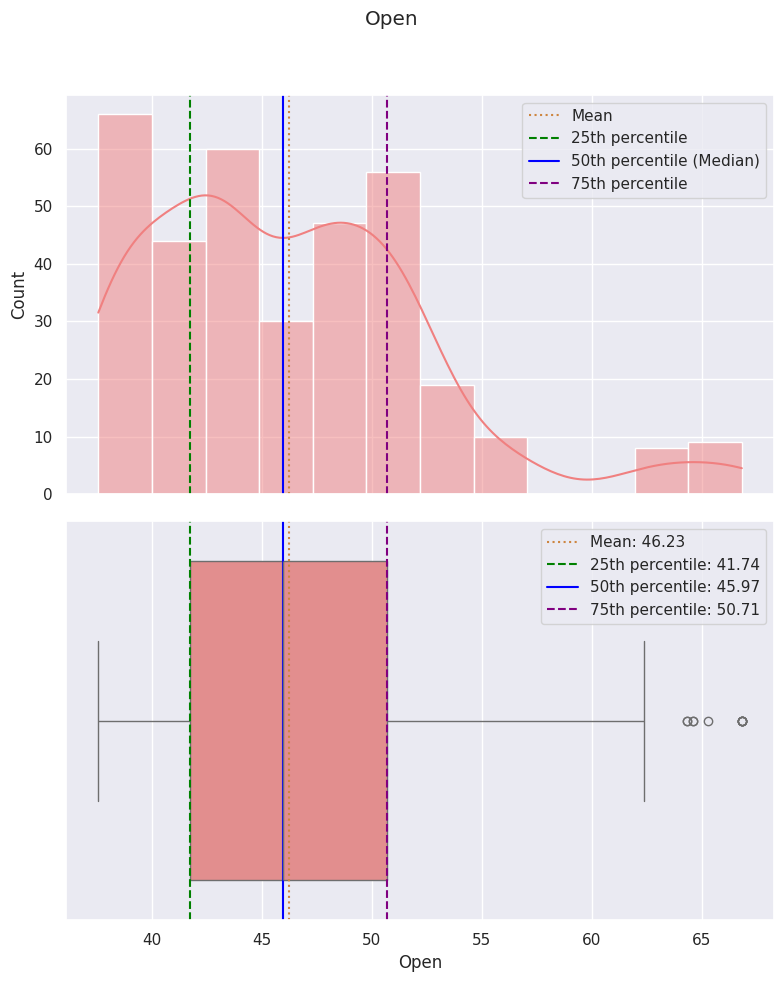

In [64]:
# Distribution of Open
plot_histogram_and_boxplot(df=data,column='Open',xlabel='Open',ylabel='Count',title='Open')

### Observations:
- Open price is slighly right skewed as well with Mean at 46.2 and Mdeian at 45.9

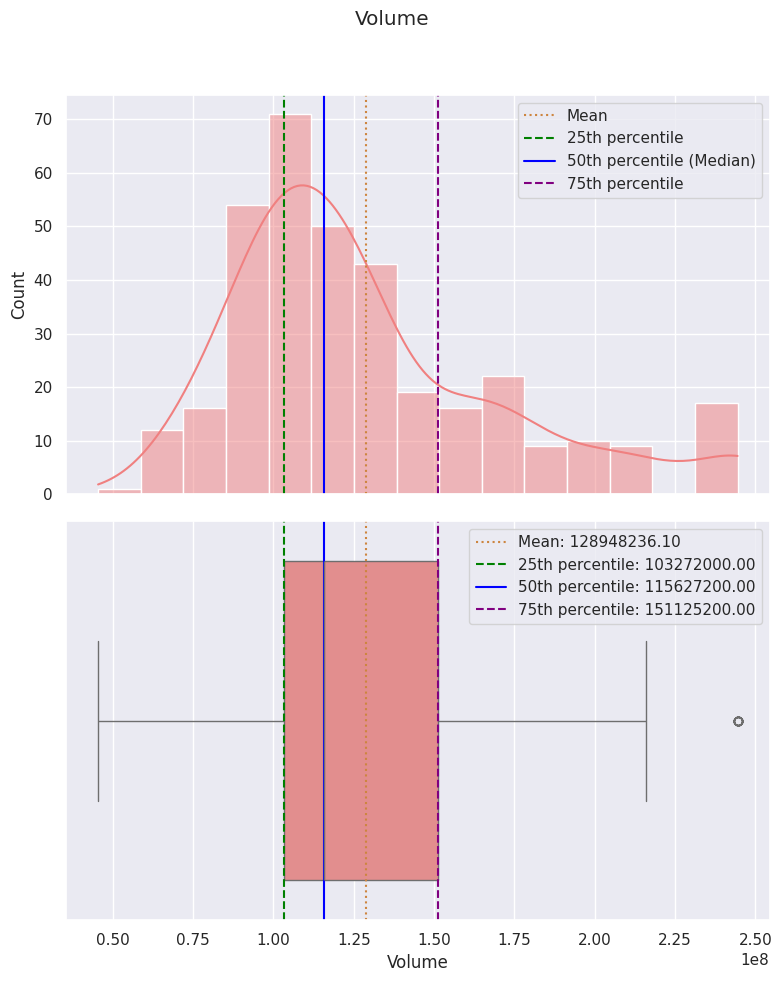

In [65]:
#Distribution of volume
plot_histogram_and_boxplot(df=data,column='Volume',xlabel='Volume',ylabel='Count',title='Volume')

### Observations:
- The distribution of volume is right skewed with mean is pull towards right where as median at left of it.
- There are some outliers as well

In [66]:
# Calculate length of news
data['length_news']=data['News'].apply(lambda x: len(x.split(' ')))
data.sort_values(by='length_news',ascending=False).head(5)

,Date,News,Open,High,Low,Close,Volume,Label,sentiment_label,length_news
342,2019-04-30,"Foxconn's Chairman, Gou, is traveling to the United States on Tuesday for a White House meeting believed to be related to an investment in Wisconsin. The company remains committed to its contract to build a display plant and tech research facilities despite reports of reconsidering plans for advanced liquid crystal display panels due to hiring mostly engineers and researchers instead",50.764999,50.849998,49.777500,48.708790,186139600,0,Neutral,61
336,2019-04-26,"Sony, the Japanese technology giant, announced a sharper than expected drop in annual profit due to a slower gaming business with the PlayStation 4 console nearing the end of its life. The company warned of significant changes to the operating environment and withdrew earnings goals for individual businesses. Gaming profits are expected to decrease due to costs for developing a",51.224998,51.250000,50.529999,49.589897,74596400,0,Neutral,61
181,2019-02-07,"Apple addressed a FaceTime privacy issue by rolling out software updates and contributing to the education of the teenager who discovered the bug, Grant Thompson from Tucson, Arizona. The bug allowed users to hear audio from people before they answered a video call. Apple formally credited Thompson and Daven Morris from Texas in its update release notes. The company conducted",50.352501,50.782501,50.340000,49.398319,67740800,-1,Negative,61
158,2019-01-30,"New York authorities are investigating Apple for not warning consumers in a timely manner about a FaceTime bug that allowed iPhone users to hear audio from others' phones before accepting video calls. The probe also covers Apple's slow response, as reports indicate a consumer alerted the company of the issue over a week before the feature was disabled. The bug",40.812500,41.537498,40.057499,39.939968,244439200,0,Neutral,61
285,2019-03-29,"Apple announced the cancellation of its AirPower wireless charging mat, a product intended to charge up to three devices at once, including an iPhone, Apple Watch, and AirPods. The company stated that it could not meet its high standards for the project and apologized to customers. Apple continues to push for wireless technology but has faced challenges with fast,",47.457500,47.520000,47.134998,46.106716,94256000,-1,Negative,60


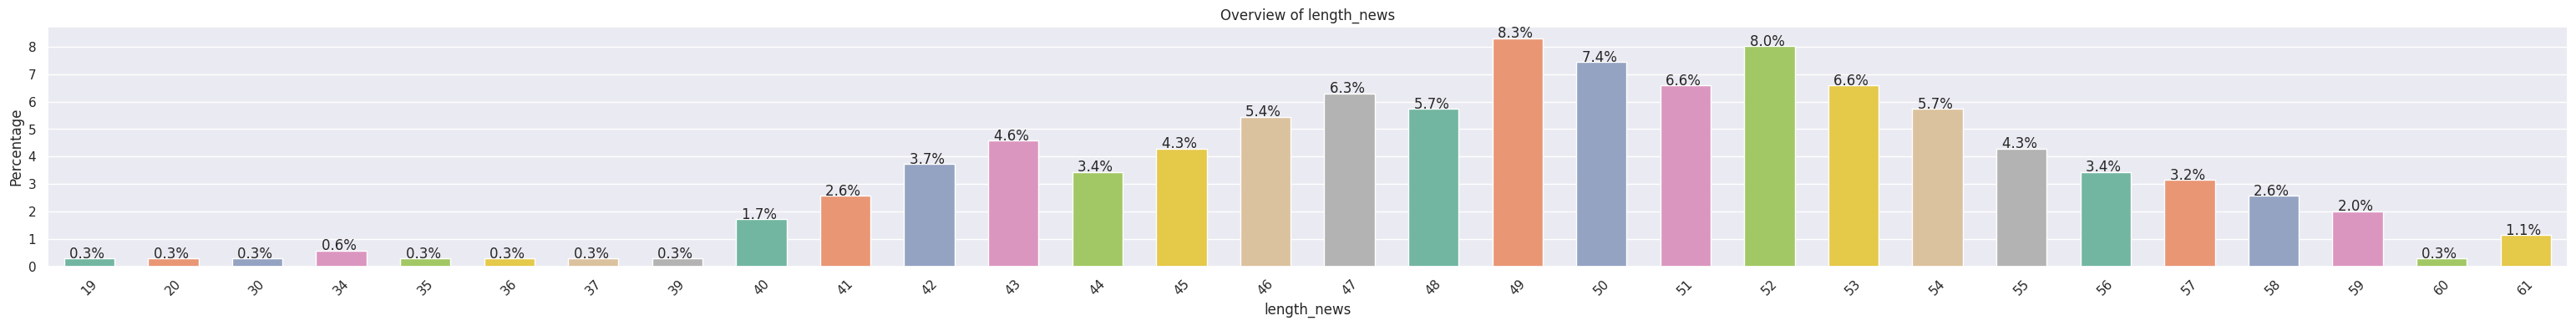

In [67]:
# Plot the bar chart for these news length
plot_bar_chart_percentage(df=data,column_name='length_news',xlabel='length_news',pellete=pellete)

### Observations:
- Highest no of words in news is 61 (1.1%)
- News with 49 words has highest Occournace followed by 52(8%)
- Some of news are very short having around 19-20 words .



---



### Bivariate AnaLysis
* Correlation
* Sentiment Polarity vs Price
* Date vs Price

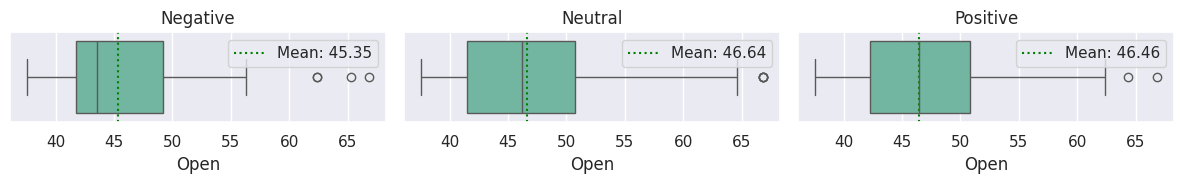

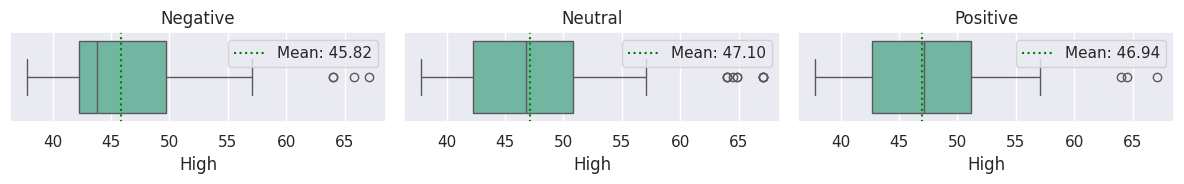

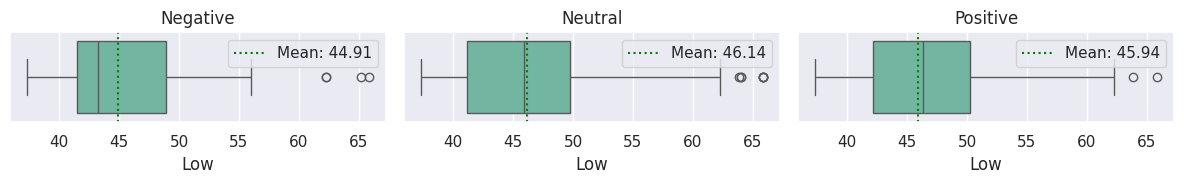

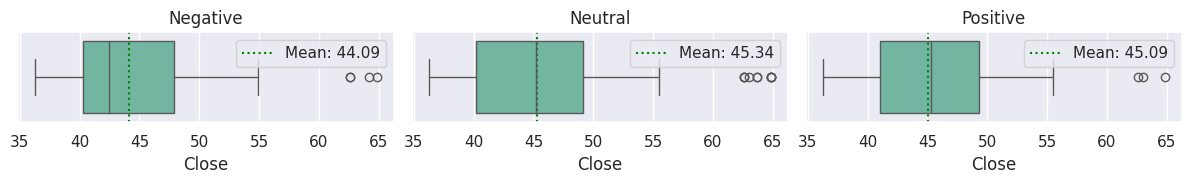

In [68]:
# Check the distribution of price across all seniments.Draw bar chart on Open,High,Low and Close
plot_box_plot_side_by_side(df=data,x='Open',xlabel='Open',category_col='sentiment_label',color=colors[0]);
plot_box_plot_side_by_side(df=data,x='High',xlabel='High',category_col='sentiment_label',color=colors[0]);
plot_box_plot_side_by_side(df=data,x='Low',xlabel='Low',category_col='sentiment_label',color=colors[0]);
plot_box_plot_side_by_side(df=data,x='Close',xlabel='Close',category_col='sentiment_label',color=colors[0]);


### Observations:
- We can see Open and Close price of nagative sentiments has lowest mean 45.35 and 44.09 respectively
- In case of Neutral sentiments the stock price closing shows highest mean (47.10)
- In case of positive sentiments the open Price is at 46.94 and close at 45.09


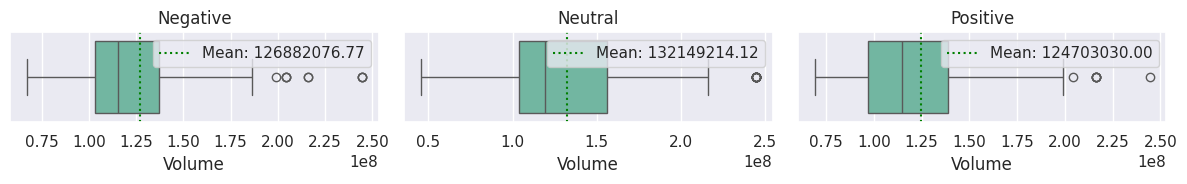

In [69]:
# Volume of shares traded on ecah price
plot_box_plot_side_by_side(df=data,x='Volume',xlabel='Volume',category_col='sentiment_label',color=colors[0]);


### Observations:
- Neutral senitiments has higher volume trades then both nagative and positive
- Nagative sentiments has higher volume trades then positive sentiments

### Date wise Mean of High ,Low,Open and Close

In [70]:
data_daily_metrics = data.groupby('Date').agg(
    {
        'Open': ['mean'],
        'High': ['mean'],
        'Low': ['mean'],
        'Close': ['mean'],
        'Volume': ['mean'],
    }
).reset_index()
data_daily_metrics.head()

,Date,Open,High,Low,Close,Volume
,,mean,mean,mean,mean,mean
0,2019-01-02,41.740002,42.244999,41.482498,40.246914,130672400.0
1,2019-01-03,43.570000,43.787498,43.222500,42.470604,103544800.0
2,2019-01-04,47.910000,47.919998,47.095001,46.419842,111448000.0
3,2019-01-07,50.792500,51.122501,50.162498,49.110790,109012000.0
4,2019-01-08,53.474998,54.507500,51.685001,50.787209,216071600.0


### Observations:
- Price behavior: There is a consistent upward movement in the mean Open, High, Low, and Close prices across the five days. This reflects a short-term bullish trend in the stock during this period.

- Volatility insights: The gap between mean High and mean Low increases slightly over the days, indicating growing intraday price volatility.

- Volume spike: The trading volume sees a significant increase on January 8, 2019, suggesting heightened market activity, possibly due to may be news announcements.


### Convert Date column to date type

In [71]:
data['Date_Converted']=pd.to_datetime(data['Date'])


In [72]:
data['Year']=data['Date_Converted'].dt.year
data['Month']=data['Date_Converted'].dt.month
data[['Year','Month']].value_counts()
#

Year  Month
2019  1        166
      3         67
      4         63
      2         53
Name: count, dtype: int64

### Observation :
- All the datas are from 2019
-  Data are from majorly from Jan .This explains why there is more trade volume in January Month

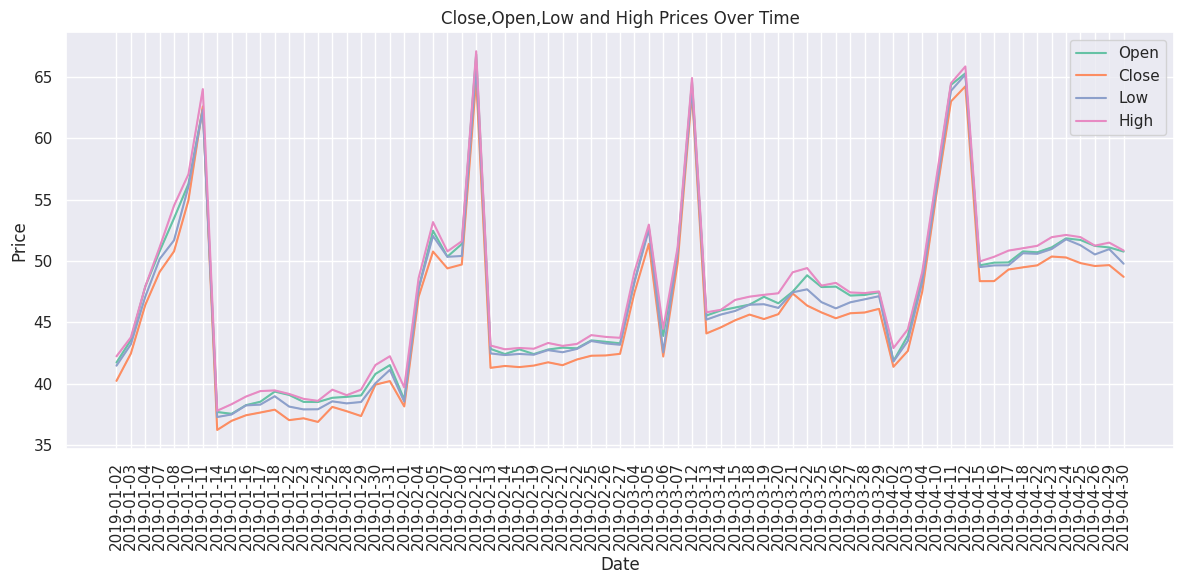

In [73]:
#Check tproce varies across the dates
plt.figure(figsize=(12, 6))
for i,value in enumerate(['Open','Close','Low','High']):
  sns.lineplot(data=data, x='Date', y=value, label=value, color=colors[i])
plt.xticks(rotation=90)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Close,Open,Low and High Prices Over Time')
plt.legend()
plt.tight_layout()
plt.show()

### Observations:
-  Its observed that around 08-02-2019 the price breached 65.
- Its observed that around 14-01-2019 the close price was lowest near to 35.

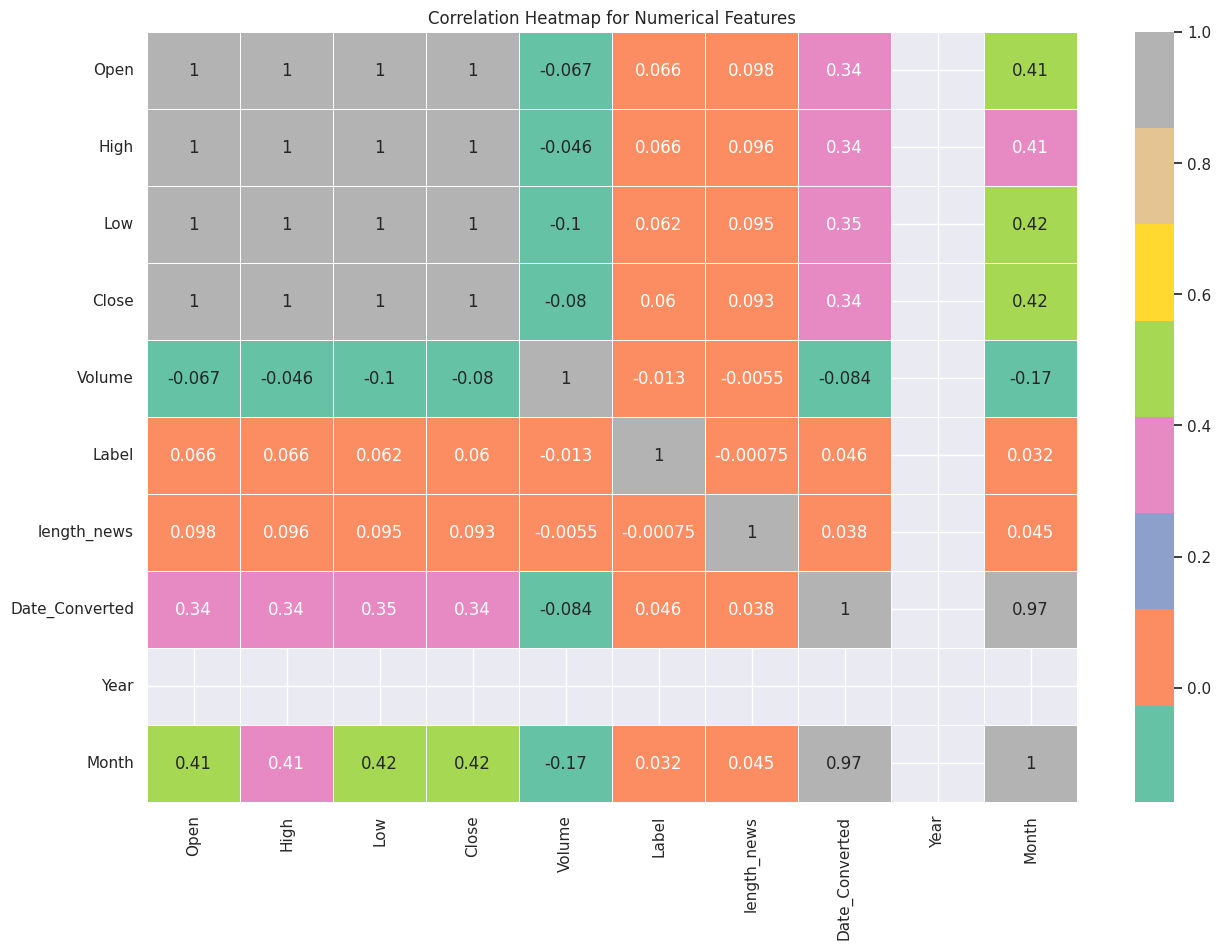

In [74]:
# Coerartion plot
plt.figure(figsize=(15, 10))
sns.heatmap(data.select_dtypes(exclude='object').corr(),annot=True,linewidths=0.5, cmap=pellete)
plt.title('Correlation Heatmap for Numerical Features')
plt.show()

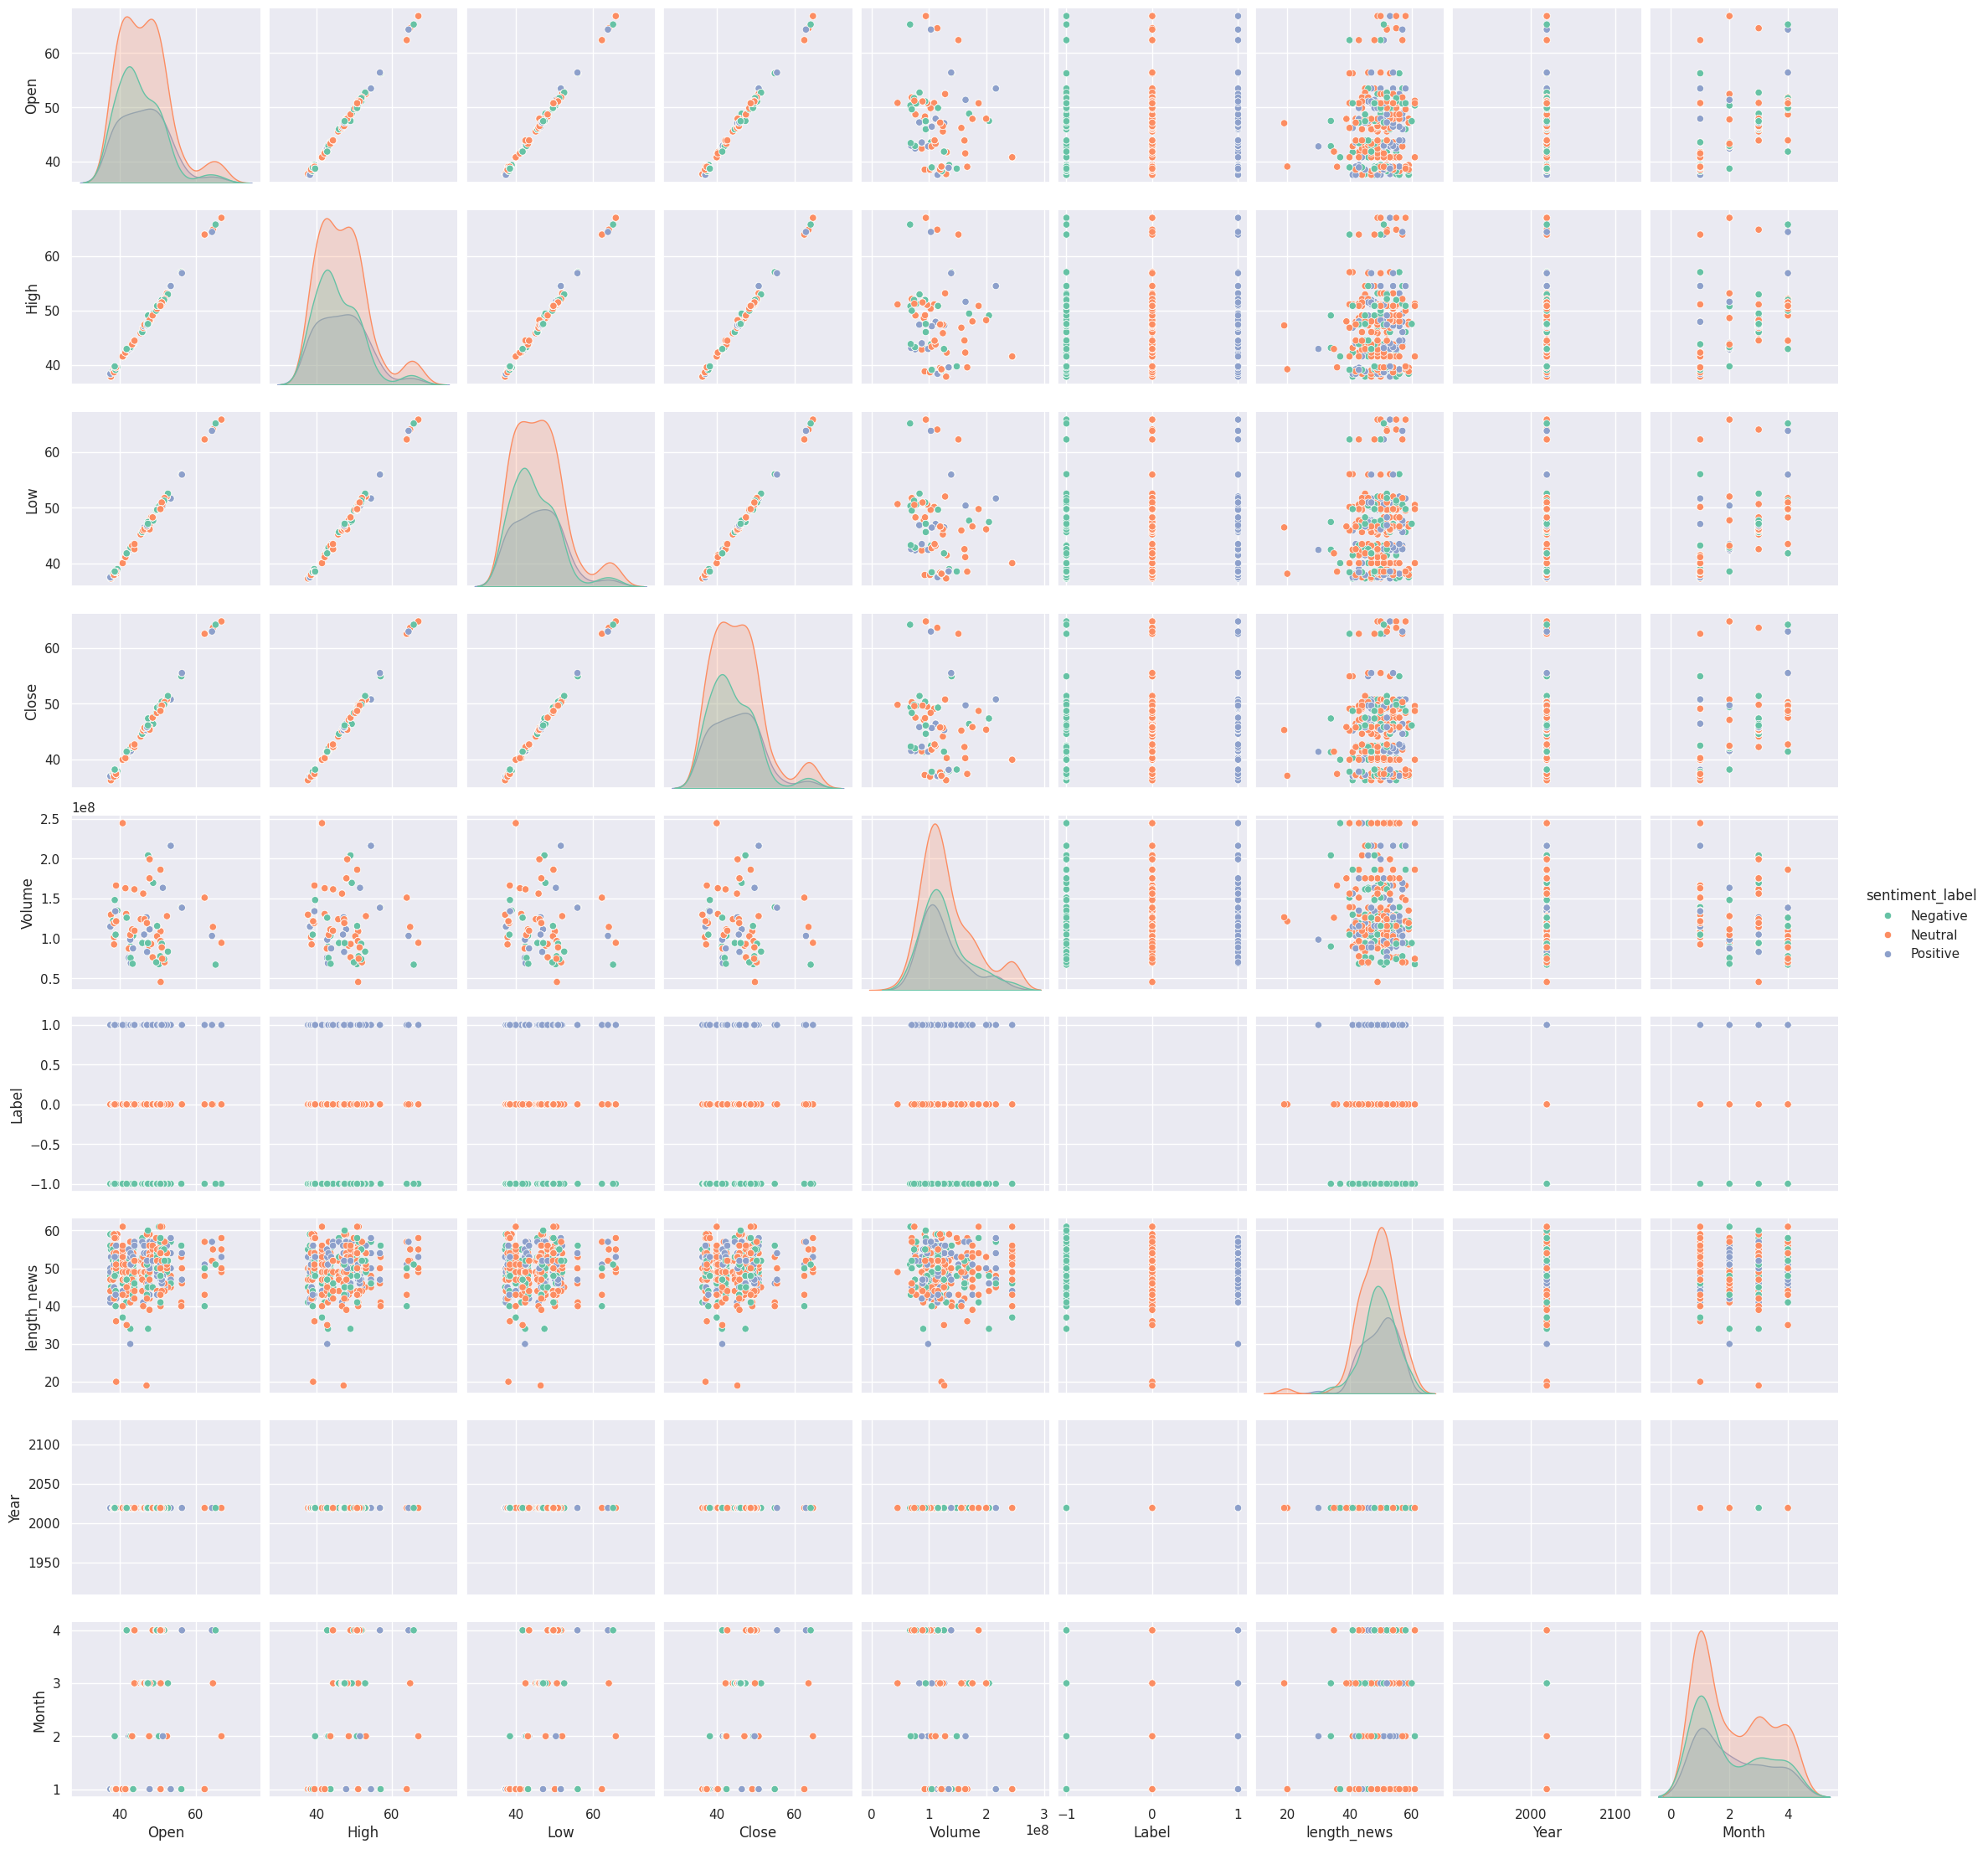

In [75]:
# pair plot to check corelation
sns.pairplot(data=data,hue='sentiment_label',palette=pellete);

### Observations:
-  Only varaible with proce like Open,Close,High,Low are highly corelated .No Other co Relation found



---



## Model Building

### Helper Utils

In [76]:
def confusion_matrix_sklearn(model, predictors, target):
    """
    To plot the confusion_matrix with percentages

    model: classifier
    predictors: independent variables
    target: dependent variable
    """
    y_pred = model.predict(predictors)
    cm = confusion_matrix(target, y_pred,labels=['Negative', 'Neutral', 'Positive'])
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(cm.shape[0], cm.shape[1])
    label_list = ['Negative', 'Neutral', 'Positive']  # Define the labels for the confusion matrix.

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=labels, fmt="",xticklabels=label_list, yticklabels=label_list)
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

In [77]:
def split(X,y):
    """
    Split the data into train and test
    """
    # Initial split into training (80%) and testing (20%)
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42)

    # Further split the temporary set into validation (10%) and test (10%) sets
    X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=42)

    return X_train,X_valid,X_test,y_train,y_valid,y_test

In [78]:
# defining a function to remove stop words using the NLTK library
def remove_stopwords(text):
    """
    Remove Stop words
    """

    # Split text into separate words
    words = text.split()

    # Removing English language stopwords
    new_text = ' '.join([word for word in words if word not in stopwords.words('english')])

    return new_text

In [79]:
# defining a function to remove special characters
def remove_special_characters(text):
    # Defining the regex pattern to match non-alphanumeric characters
    pattern = '[^A-Za-z0-9]+'

    # Finding the specified pattern and replacing non-alphanumeric characters with a blank string
    new_text = ''.join(re.sub(pattern, ' ', text))

    return new_text

In [80]:
def pos_tagger(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

In [81]:
# defining a function to perform stemming
def apply_lemmatizer(text):
    # Split text into separate words
    wnl = WordNetLemmatizer() #

    pos_tagged = nltk.pos_tag(nltk.word_tokenize(text))
    wordnet_tagged = list(map(lambda x: (x[0], pos_tagger(x[1])), pos_tagged))
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            # if there is no available tag, append the token as i s
            lemmatized_sentence.append(word)
        else:
            # else use the tag to lemmatize the token
            lemmatized_sentence.append(wnl.lemmatize(word, tag))
    lemmatized_sentence = " ".join(lemmatized_sentence)
    return lemmatized_sentence



---



### Data Preprocessing

Removing special characters


In [82]:
data.columns

Index(['Date', 'News', 'Open', 'High', 'Low', 'Close', 'Volume', 'Label',
       'sentiment_label', 'length_news', 'Date_Converted', 'Year', 'Month'],
      dtype='object')

In [83]:
embedding_model_data=data.copy()

In [84]:
# Applying the function to remove special characters
embedding_model_data['cleaned_news'] = embedding_model_data['News'].apply(remove_special_characters)

In [85]:
# Show first 3
embedding_model_data.loc[0:2,['News','cleaned_news']]

,News,cleaned_news
0,"The tech sector experienced a significant decline in the aftermarket following Apple's Q1 revenue warning. Notable suppliers, including Skyworks, Broadcom, Lumentum, Qorvo, and TSMC, saw their stocks drop in response to Apple's downward revision of its revenue expectations for the quarter, previously announced in January.",The tech sector experienced a significant decline in the aftermarket following Apple s Q1 revenue warning Notable suppliers including Skyworks Broadcom Lumentum Qorvo and TSMC saw their stocks drop in response to Apple s downward revision of its revenue expectations for the quarter previously announced in January
1,"Apple lowered its fiscal Q1 revenue guidance to $84 billion from earlier estimates of $89-$93 billion due to weaker than expected iPhone sales. The announcement caused a significant drop in Apple's stock price and negatively impacted related suppliers, leading to broader market declines for tech indices such as Nasdaq 10",Apple lowered its fiscal Q1 revenue guidance to 84 billion from earlier estimates of 89 93 billion due to weaker than expected iPhone sales The announcement caused a significant drop in Apple s stock price and negatively impacted related suppliers leading to broader market declines for tech indices such as Nasdaq 10
2,"Apple cut its fiscal first quarter revenue forecast from $89-$93 billion to $84 billion due to weaker demand in China and fewer iPhone upgrades. CEO Tim Cook also mentioned constrained sales of Airpods and Macbooks. Apple's shares fell 8.5% in post market trading, while Asian suppliers like Hon",Apple cut its fiscal first quarter revenue forecast from 89 93 billion to 84 billion due to weaker demand in China and fewer iPhone upgrades CEO Tim Cook also mentioned constrained sales of Airpods and Macbooks Apple s shares fell 8 5 in post market trading while Asian suppliers like Hon


### Observations:
We can see all special charcters like $ ,% removed

In [86]:
# removing extra whitespaces from the text
embedding_model_data['cleaned_news'] = embedding_model_data['cleaned_news'].str.strip()

In [87]:
 #Applying the function to remove stop words using the NLTK library
embedding_model_data['cleaned_news_without_stop_words'] = embedding_model_data['cleaned_news'].apply(remove_stopwords)

In [88]:
# Show first 3
embedding_model_data.loc[0:3,['cleaned_news','cleaned_news_without_stop_words']]


,cleaned_news,cleaned_news_without_stop_words
0,The tech sector experienced a significant decline in the aftermarket following Apple s Q1 revenue warning Notable suppliers including Skyworks Broadcom Lumentum Qorvo and TSMC saw their stocks drop in response to Apple s downward revision of its revenue expectations for the quarter previously announced in January,The tech sector experienced significant decline aftermarket following Apple Q1 revenue warning Notable suppliers including Skyworks Broadcom Lumentum Qorvo TSMC saw stocks drop response Apple downward revision revenue expectations quarter previously announced January
1,Apple lowered its fiscal Q1 revenue guidance to 84 billion from earlier estimates of 89 93 billion due to weaker than expected iPhone sales The announcement caused a significant drop in Apple s stock price and negatively impacted related suppliers leading to broader market declines for tech indices such as Nasdaq 10,Apple lowered fiscal Q1 revenue guidance 84 billion earlier estimates 89 93 billion due weaker expected iPhone sales The announcement caused significant drop Apple stock price negatively impacted related suppliers leading broader market declines tech indices Nasdaq 10
2,Apple cut its fiscal first quarter revenue forecast from 89 93 billion to 84 billion due to weaker demand in China and fewer iPhone upgrades CEO Tim Cook also mentioned constrained sales of Airpods and Macbooks Apple s shares fell 8 5 in post market trading while Asian suppliers like Hon,Apple cut fiscal first quarter revenue forecast 89 93 billion 84 billion due weaker demand China fewer iPhone upgrades CEO Tim Cook also mentioned constrained sales Airpods Macbooks Apple shares fell 8 5 post market trading Asian suppliers like Hon
3,This news article reports that yields on long dated U S Treasury securities hit their lowest levels in nearly a year on January 2 2019 due to concerns about the health of the global economy following weak economic data from China and Europe as well as the partial U S government shutdown Apple,This news article reports yields long dated U S Treasury securities hit lowest levels nearly year January 2 2019 due concerns health global economy following weak economic data China Europe well partial U S government shutdown Apple


### Stemming and Lemmatizer
Stemming  and Lemmatizer is a language processing method that chops off word endings to find the root or base form of words.


In [89]:
# Applying the function to perform Lemmatizer
embedding_model_data['final_cleaned_news'] = embedding_model_data['cleaned_news_without_stop_words'].apply(apply_lemmatizer)

In [90]:
# Show first 3
embedding_model_data.loc[0:3,['final_cleaned_news','cleaned_news_without_stop_words']]


,final_cleaned_news,cleaned_news_without_stop_words
0,The tech sector experience significant decline aftermarket follow Apple Q1 revenue warn Notable supplier include Skyworks Broadcom Lumentum Qorvo TSMC saw stock drop response Apple downward revision revenue expectation quarter previously announce January,The tech sector experienced significant decline aftermarket following Apple Q1 revenue warning Notable suppliers including Skyworks Broadcom Lumentum Qorvo TSMC saw stocks drop response Apple downward revision revenue expectations quarter previously announced January
1,Apple lower fiscal Q1 revenue guidance 84 billion early estimate 89 93 billion due weaker expect iPhone sale The announcement cause significant drop Apple stock price negatively impact related supplier lead broader market decline tech index Nasdaq 10,Apple lowered fiscal Q1 revenue guidance 84 billion earlier estimates 89 93 billion due weaker expected iPhone sales The announcement caused significant drop Apple stock price negatively impacted related suppliers leading broader market declines tech indices Nasdaq 10
2,Apple cut fiscal first quarter revenue forecast 89 93 billion 84 billion due weak demand China few iPhone upgrade CEO Tim Cook also mention constrain sale Airpods Macbooks Apple share fell 8 5 post market trading Asian supplier like Hon,Apple cut fiscal first quarter revenue forecast 89 93 billion 84 billion due weaker demand China fewer iPhone upgrades CEO Tim Cook also mentioned constrained sales Airpods Macbooks Apple shares fell 8 5 post market trading Asian suppliers like Hon
3,This news article report yield long dated U S Treasury security hit low level nearly year January 2 2019 due concern health global economy follow weak economic data China Europe well partial U S government shutdown Apple,This news article reports yields long dated U S Treasury securities hit lowest levels nearly year January 2 2019 due concerns health global economy following weak economic data China Europe well partial U S government shutdown Apple


### Observations:
Apply Lemmatizer so that workd like strongest will become strong and weaker will become weak .It's used to convert word to word to its base or dictionary form.

# **Word Embeddings**

## Word2Vec

In [91]:
# creating a list of all words in our data
words_list = [item.split(" ") for item in embedding_model_data['final_cleaned_news'].values]

In [92]:
words_list[0:2]

[['The',
  'tech',
  'sector',
  'experience',
  'significant',
  'decline',
  'aftermarket',
  'follow',
  'Apple',
  'Q1',
  'revenue',
  'warn',
  'Notable',
  'supplier',
  'include',
  'Skyworks',
  'Broadcom',
  'Lumentum',
  'Qorvo',
  'TSMC',
  'saw',
  'stock',
  'drop',
  'response',
  'Apple',
  'downward',
  'revision',
  'revenue',
  'expectation',
  'quarter',
  'previously',
  'announce',
  'January'],
 ['Apple',
  'lower',
  'fiscal',
  'Q1',
  'revenue',
  'guidance',
  '84',
  'billion',
  'early',
  'estimate',
  '89',
  '93',
  'billion',
  'due',
  'weaker',
  'expect',
  'iPhone',
  'sale',
  'The',
  'announcement',
  'cause',
  'significant',
  'drop',
  'Apple',
  'stock',
  'price',
  'negatively',
  'impact',
  'related',
  'supplier',
  'lead',
  'broader',
  'market',
  'decline',
  'tech',
  'index',
  'Nasdaq',
  '10']]

Show first 2 word

In [93]:
# creating an instance of Word2Vec
model_W2V = Word2Vec(words_list, min_count = 1, workers = 6,vector_size=100)

In [94]:
# Checking the size of the vocabulary
print("Length of the vocabulary is", len(list(model_W2V.wv.key_to_index)))

Length of the vocabulary is 3055


Length of vocabulary is 3055

In [95]:
print(model_W2V.wv.key_to_index)

{'The': 0, 'Apple': 1, 'S': 2, 'China': 3, 'stock': 4, 'report': 5, 'due': 6, 'company': 7, 'U': 8, 'price': 9, 'revenue': 10, 'market': 11, 'year': 12, 'trade': 13, 'sale': 14, 'decline': 15, 'This': 16, 'lead': 17, 'share': 18, 'billion': 19, 'concern': 20, 'earnings': 21, 'service': 22, 'new': 23, 'follow': 24, 'expect': 25, 'iPhone': 26, 'In': 27, 'P': 28, 'economic': 29, '500': 30, 'tech': 31, 'quarter': 32, 'Chinese': 33, 'gain': 34, 'million': 35, 'growth': 36, 'US': 37, 'weak': 38, 'announce': 39, 'drop': 40, 'include': 41, '1': 42, 'first': 43, 'loss': 44, 'forecast': 45, 'significant': 46, 'demand': 47, 'increase': 48, 'Dow': 49, 'investor': 50, 'rise': 51, 'news': 52, 'plan': 53, 'global': 54, 'cut': 55, 'app': 56, '0': 57, 'Google': 58, 'use': 59, 'business': 60, 'Facebook': 61, 'user': 62, 'profit': 63, 'also': 64, 'potential': 65, '5': 66, 'article': 67, '3': 68, 'surge': 69, 'data': 70, 'smartphone': 71, 'low': 72, 'major': 73, 'warn': 74, 'Nasdaq': 75, 'high': 76, 'reac

In [96]:
# Checking the word embedding of a random word
word = "stock"
model_W2V.wv[word]

array([-0.02727171,  0.02241451, -0.00133044, -0.00360627,  0.00648214,
       -0.0339375 ,  0.00933531,  0.04647087, -0.01346552, -0.00613395,
       -0.01817691, -0.02760773, -0.00887334,  0.01775583,  0.00377618,
       -0.02231136,  0.0024814 , -0.02240177,  0.00804043, -0.04501811,
        0.01305995, -0.00261903,  0.01717261, -0.00042087, -0.00862242,
        0.00742011, -0.01479742, -0.01017012, -0.02968669,  0.00573533,
        0.03075926,  0.01107782,  0.00187761, -0.02285824, -0.00293261,
        0.02541653, -0.00392688, -0.01208039, -0.01214056, -0.04173965,
        0.0042282 , -0.02552033, -0.01924623,  0.00935133,  0.0256654 ,
       -0.01506275, -0.01028112, -0.00143251,  0.01850538,  0.00797404,
        0.01347892, -0.02024073,  0.00281584, -0.00215832, -0.01657365,
        0.01332604,  0.00492832, -0.00951513, -0.03159135, -0.00065818,
        0.01128931,  0.00481788, -0.00459205, -0.00605908, -0.02847269,
        0.01673502,  0.01278087,  0.02258806, -0.03267278,  0.03

In [97]:
# Dictionary with key as words and the value as the embedding vector.
words = model_W2V.wv.key_to_index

In [98]:
def average_vectorizer_Word2Vec(doc):
    # Initializing a feature vector for the sentence
    feature_vector = np.zeros((vec_size,), dtype="float64")

    # Creating a list of words in the sentence that are present in the model vocabulary
    words_in_vocab = [word for word in doc.split() if word in words]

    # adding the vector representations of the words
    for word in words_in_vocab:
        feature_vector +=  model_W2V.wv[word]

    # Dividing by the number of words to get the average vector
    if len(words_in_vocab) != 0:
        feature_vector /= len(words_in_vocab)

    return feature_vector

In [99]:
print(model_W2V.vector_size)

100


Default vector size is 100

In [100]:
# creating a dataframe of the vectorized documents

vec_size = 100
df_word2vec = pd.DataFrame(
    embedding_model_data['final_cleaned_news'].apply(average_vectorizer_Word2Vec).tolist(),
    columns=['Feature ' + str(i) for i in range(vec_size)]
)


### Observation:
We have taken vector size as 100 in word 2 vec to create vectroizer

In [101]:
df_word2vec

,Feature 0,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,Feature 9,...,Feature 90,Feature 91,Feature 92,Feature 93,Feature 94,Feature 95,Feature 96,Feature 97,Feature 98,Feature 99
0,-0.008489,0.010720,0.003477,-0.001864,0.001098,-0.021559,0.002795,0.025066,-0.005893,-0.007874,...,0.014839,0.006805,0.001765,0.006159,0.017471,0.012664,0.007153,-0.014944,0.002400,0.000212
1,-0.012893,0.012518,0.002882,0.000149,0.001431,-0.023070,0.004966,0.025446,-0.006064,-0.007759,...,0.015069,0.006203,0.000845,0.005065,0.019427,0.011842,0.005732,-0.012980,0.001956,0.000917
2,-0.009275,0.010249,0.002384,-0.000073,0.002575,-0.020619,0.004365,0.024170,-0.005165,-0.008664,...,0.012763,0.004291,-0.000140,0.006060,0.016655,0.010186,0.005007,-0.012613,0.002797,0.000244
3,-0.012856,0.012256,0.002939,-0.001556,0.003815,-0.019773,0.005811,0.024404,-0.006567,-0.005768,...,0.014423,0.007773,0.001474,0.007035,0.022089,0.014778,0.006434,-0.014628,0.002921,-0.000735
4,-0.008650,0.009611,0.003291,-0.000409,0.000207,-0.018782,0.002982,0.020358,-0.004599,-0.006837,...,0.011212,0.005187,0.002128,0.004380,0.014552,0.009791,0.005930,-0.009445,0.002054,-0.000769
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
344,-0.001162,0.000926,0.001936,-0.001474,0.001915,-0.002768,0.002094,0.004448,-0.001781,-0.003784,...,0.002203,0.001454,0.000997,0.001739,0.004074,0.002465,0.001166,-0.001143,0.000394,-0.002279
345,-0.006468,0.007863,0.002317,-0.000547,0.002104,-0.015024,0.003118,0.015030,-0.003695,-0.003602,...,0.008426,0.003974,-0.000465,0.004487,0.013394,0.009644,0.003983,-0.009980,0.001844,0.000738
346,-0.007594,0.010629,0.002820,-0.000731,0.001253,-0.016887,0.004337,0.020534,-0.003460,-0.005328,...,0.011690,0.005815,0.000959,0.006139,0.016084,0.010804,0.004240,-0.010812,0.002795,0.000318
347,-0.008350,0.010317,0.003220,0.000103,0.002396,-0.018712,0.004315,0.023353,-0.006326,-0.008092,...,0.014084,0.007117,0.001507,0.004525,0.019459,0.012638,0.003705,-0.011906,0.001998,-0.000781


Showing all features (1-100)  for the words

### GloVe

In [85]:
# load the Stanford GloVe model
glove_path = '/content/drive/MyDrive/Python Course_shared/NLP/glove.6B.100d.txt.word2vec'
glove_model = KeyedVectors.load_word2vec_format(glove_path, binary=False)

In [86]:
# Checking the size of the vocabulary
print("Length of the vocabulary is", len(glove_model.index_to_key))

Length of the vocabulary is 400000


Length of vocab here is 400000

In [87]:
# Checking the word embedding of a random word
word = "good"
glove_model[word]

array([-0.030769 ,  0.11993  ,  0.53909  , -0.43696  , -0.73937  ,
       -0.15345  ,  0.081126 , -0.38559  , -0.68797  , -0.41632  ,
       -0.13183  , -0.24922  ,  0.441    ,  0.085919 ,  0.20871  ,
       -0.063582 ,  0.062228 , -0.051234 , -0.13398  ,  1.1418   ,
        0.036526 ,  0.49029  , -0.24567  , -0.412    ,  0.12349  ,
        0.41336  , -0.48397  , -0.54243  , -0.27787  , -0.26015  ,
       -0.38485  ,  0.78656  ,  0.1023   , -0.20712  ,  0.40751  ,
        0.32026  , -0.51052  ,  0.48362  , -0.0099498, -0.38685  ,
        0.034975 , -0.167    ,  0.4237   , -0.54164  , -0.30323  ,
       -0.36983  ,  0.082836 , -0.52538  , -0.064531 , -1.398    ,
       -0.14873  , -0.35327  , -0.1118   ,  1.0912   ,  0.095864 ,
       -2.8129   ,  0.45238  ,  0.46213  ,  1.6012   , -0.20837  ,
       -0.27377  ,  0.71197  , -1.0754   , -0.046974 ,  0.67479  ,
       -0.065839 ,  0.75824  ,  0.39405  ,  0.15507  , -0.64719  ,
        0.32796  , -0.031748 ,  0.52899  , -0.43886  ,  0.6740

In [88]:
result = glove_model.most_similar("good", topn=5)
print(result)

[('better', 0.893191397190094), ('sure', 0.8314563035964966), ('really', 0.8297762274742126), ('kind', 0.8288268446922302), ('very', 0.8260800242424011)]


### Observations:
We can see similar word as good like better very really imn above

In [89]:
# Store the glove vector in dict
glove_words = glove_model.index_to_key
glove_word_vector_dict = dict(zip(glove_model.index_to_key,list(glove_model.vectors)))


In [90]:
# SHow for one word
glove_word_vector_dict['bad']

array([ 0.39456  , -0.24717  ,  1.0319   , -0.61444  , -1.2376   ,
        0.051794 , -0.55112  , -0.31014  , -0.025735 , -0.24709  ,
        0.25836  ,  0.34899  ,  0.46176  ,  0.44237  ,  0.354    ,
        0.21262  , -0.26312  , -0.17128  ,  0.44013  ,  1.1284   ,
        0.37259  ,  0.41969  , -0.2534   , -0.051885 , -0.34917  ,
        0.15298  , -0.68444  , -0.19514  , -0.018647 ,  0.084191 ,
        0.14569  ,  0.3869   ,  0.023524 , -0.37861  , -0.65081  ,
        0.010398 , -0.50087  , -0.087368 ,  0.098617 , -0.21907  ,
       -0.072412 , -0.10247  , -0.3148   , -0.307    , -0.30457  ,
       -0.14329  ,  0.10313  , -0.040487 , -0.095922 , -1.192    ,
       -0.063356 ,  0.034127 , -0.057674 ,  0.56582  ,  0.082541 ,
       -2.4617   ,  0.48029  ,  0.72806  ,  1.2841   ,  0.10672  ,
       -0.045119 ,  1.0117   , -0.97928  ,  0.022828 ,  0.46876  ,
       -0.026875 ,  0.80018  , -0.23101  ,  0.086699 , -0.74338  ,
       -0.38738  , -0.1924   , -0.13292  ,  0.52347  ,  0.3565

Show the vectoriser for word bad

In [91]:
#Function to get average vectorizer
def average_vectorizer_GloVe(doc):
    # Initializing a feature vector for the sentence
    feature_vector = np.zeros((vec_size,), dtype="float64")

    # Creating a list of words in the sentence that are present in the model vocabulary
    words_in_vocab = [word for word in doc.split() if word in glove_words]

    # adding the vector representations of the words
    for word in words_in_vocab:
        feature_vector += np.array(glove_word_vector_dict[word])

    # Dividing by the number of words to get the average vector
    if len(words_in_vocab) != 0:
        feature_vector /= len(words_in_vocab)

    return feature_vector

In [92]:
vec_size=100
# creating a dataframe of the vectorized documents
df_Glove = pd.DataFrame(embedding_model_data['final_cleaned_news'].apply(average_vectorizer_GloVe).tolist(), columns=['Feature '+str(i) for i in range(vec_size)])
df_Glove

,Feature 0,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,Feature 9,...,Feature 90,Feature 91,Feature 92,Feature 93,Feature 94,Feature 95,Feature 96,Feature 97,Feature 98,Feature 99
0,0.002931,0.145784,0.200871,0.032062,0.007315,-0.604357,-0.218967,-0.027811,0.025237,-0.091141,...,0.052845,0.094210,-0.404989,-0.311762,-0.367160,0.073361,0.158416,-0.121352,0.556477,0.039143
1,0.156658,0.344386,0.288481,0.053615,-0.019687,-0.637876,-0.095368,-0.141418,-0.172501,-0.033686,...,-0.000731,0.143911,-0.339556,-0.213472,-0.593490,0.267038,0.218550,-0.148648,0.588949,-0.170693
2,0.088791,0.265116,0.337455,-0.023365,0.102949,-0.471540,-0.061020,0.029918,-0.172245,-0.008734,...,0.055167,0.189365,-0.215968,-0.276059,-0.738681,0.151654,0.145376,-0.058070,0.598893,-0.164304
3,-0.178062,0.231505,0.380694,0.049858,-0.089505,-0.390801,-0.227763,0.019159,-0.046815,-0.036439,...,0.118706,0.224557,-0.354199,0.030956,-0.457738,0.219986,0.157983,-0.311727,0.424489,-0.040333
4,0.073264,0.214276,0.302618,0.023881,-0.074869,-0.461132,-0.212628,-0.282494,-0.180190,-0.056330,...,0.009289,0.215017,-0.191389,-0.404256,-0.343157,0.217285,0.205403,-0.162037,0.349607,-0.060130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
344,-0.044932,0.287049,0.389091,-0.104637,0.061294,0.072045,-0.089317,-0.037990,0.053062,-0.026949,...,0.206845,-0.081179,-0.056968,-0.072345,-0.437725,-0.031501,-0.177675,-0.222750,0.324149,0.138735
345,0.183219,0.369917,0.170079,0.099235,-0.084823,-0.426484,-0.136860,-0.068317,-0.192881,-0.183390,...,-0.031193,0.272789,-0.192536,-0.065833,-0.633486,0.297512,0.246202,-0.162093,0.475751,-0.034242
346,0.078527,0.091057,0.285284,-0.143611,0.109947,-0.261332,-0.062210,0.065133,-0.420995,-0.113363,...,-0.066592,0.192491,-0.206279,-0.084367,-0.493240,0.173699,-0.010281,-0.089646,0.447618,-0.008679
347,-0.092119,0.099043,0.308753,0.047759,-0.063015,-0.624220,-0.303199,-0.098812,-0.164085,-0.185968,...,0.004200,0.109175,-0.143915,-0.271224,-0.535217,0.132054,0.338926,-0.260885,0.551226,0.076166


Taken Vectoriser as 100  and showing vectors

### Sentence Transformer

#### Defining the model

In [93]:
# Defining the model
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

In [94]:
# setting the device to GPU if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [95]:
data.columns

Index(['Date', 'News', 'Open', 'High', 'Low', 'Close', 'Volume', 'Label',
       'sentiment_label'],
      dtype='object')

In [96]:
embedding_matrix = model.encode(data['News'], device=device, show_progress_bar=True)

Batches:   0%|          | 0/11 [00:00<?, ?it/s]

In [97]:
# printing the shape of the embedding matrix
embedding_matrix.shape

(349, 384)

We can see sentenece Transformer generred as 349,384 dimensions vector .

In [98]:
# printing the embedding vector of the first review in the dataset
embedding_matrix[0,:]

array([-2.02313159e-03, -3.67734767e-02,  7.73542821e-02,  4.67134863e-02,
        3.25521603e-02,  2.10235314e-03,  4.32834662e-02,  3.95345129e-02,
        5.82279675e-02,  8.87510274e-03,  7.09636360e-02,  4.99076843e-02,
        6.46608472e-02, -4.97969892e-03, -1.30518824e-02, -2.98355483e-02,
       -8.91323388e-03, -7.82000571e-02, -2.17109602e-02, -5.24823181e-02,
       -5.14276326e-02, -3.30719724e-02, -3.32051739e-02,  4.18126024e-02,
        7.99547434e-02,  1.54092591e-02, -2.15781815e-02,  5.19439541e-02,
       -4.65799198e-02, -3.71372215e-02, -1.04225568e-01,  9.86079201e-02,
        5.21786660e-02,  3.46579105e-02,  1.48810120e-02, -4.47349763e-03,
        5.70117570e-02, -2.41722949e-02,  2.14048848e-02, -6.52144775e-02,
       -3.30644958e-02,  1.61960311e-02, -6.63141757e-02,  4.39942963e-02,
        3.82153057e-02, -4.86519225e-02,  1.62651595e-02, -4.02664989e-02,
       -3.34572373e-03,  3.20955552e-02, -3.91194923e-03, -1.26830228e-02,
        4.49699089e-02,  

Show the first vectoriser which is of shape 384

### Data Prepration  Train test Split

### Train Test Validation Split

In [99]:
data.columns

Index(['Date', 'News', 'Open', 'High', 'Low', 'Close', 'Volume', 'Label',
       'sentiment_label'],
      dtype='object')

In [102]:
# Creating dependent and independent variables
X_word2vec = df_word2vec.copy()
X_glove = df_Glove.copy()
X_sentence_transformers = embedding_matrix
y = data['sentiment_label']

In [103]:
# Divide each of the embeddings in to train validarion and test set
X_train_word2vec,X_valid_word2vec,X_test_word2vec,y_train_word2vec,y_valid_word2vec,y_test_word2vec=split(X_word2vec,y)
X_train_glove,X_valid_glove,X_test_glove,y_train_glove,y_valid_glove,y_test_glove=split(X_glove,y)
X_train_st,X_valid_st,X_test_st,y_train_st,y_valid_st,y_test_st=split(X_sentence_transformers,y)

In [122]:
print("Training Set word2vec",X_train_word2vec.shape,"Validation Set word2vec",X_valid_word2vec.shape,"Testing Set word2vec",X_test_word2vec.shape)
print("Training Set Glove",X_train_glove.shape,"Validation Set Glove",X_valid_glove.shape,"Testing Set Glove",X_test_glove.shape)
print("Training Set SentenceTransformer",X_train_st.shape,"Validation Set SentenceTransformer",X_valid_st.shape,"Testing Set SentenceTransformer",X_test_st.shape)

Training Set word2vec (279, 100) Validation Set word2vec (35, 100) Testing Set word2vec (35, 100)
Training Set Glove (279, 100) Validation Set Glove (35, 100) Testing Set Glove (35, 100)
Training Set SentenceTransformer (279, 384) Validation Set SentenceTransformer (35, 384) Testing Set SentenceTransformer (35, 384)


We can see training set have around 279 data points where as test and vlaidation set has 35 each

## Machine Learning Model Building


Metrics To Consider :**F1 Score** is the harmonic mean of precision and recall, and it balances both, which is critical when false positives and false negatives are both costly (e.g., wrongly assuming bullish sentiment can mislead)

### Random Forest Model (default with Word2Vec)

In [103]:
data['sentiment_label'].unique()

array(['Nagative', 'Neutral', 'Positive'], dtype=object)

In [123]:
# Building the model
rf_word2vec = RandomForestClassifier(random_state = 42)

# Fitting on train data
rf_word2vec.fit(X_train_word2vec, y_train_word2vec)

RandomForestClassifier(random_state=42)

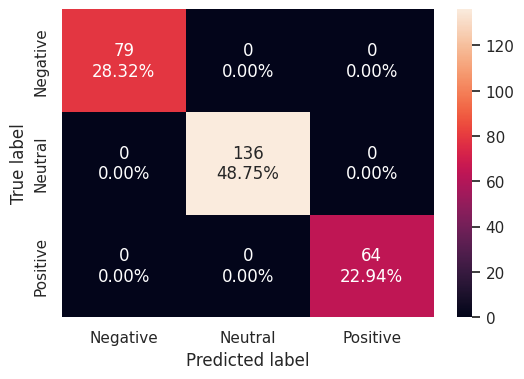

In [125]:
confusion_matrix_sklearn(rf_word2vec, X_train_word2vec, y_train_word2vec)

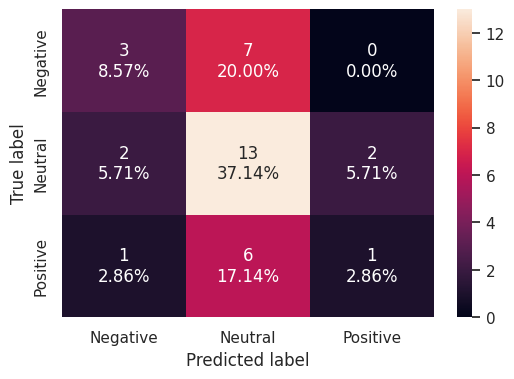

In [126]:
confusion_matrix_sklearn(rf_word2vec, X_valid_word2vec, y_valid_word2vec)

### Observations:
There seems to be clear Overfitting here .As ML model preducted correctly everything in training where as struggle in validation

In [127]:
# Predicting on train data
y_pred_train_word2vec = rf_word2vec.predict(X_train_word2vec)

# Predicting on validation data
y_pred_valid_word2vec = rf_word2vec.predict(X_valid_word2vec)

### Classification Report

In [128]:
print(classification_report(y_train_word2vec, y_pred_train_word2vec))

              precision    recall  f1-score   support

    Negative       1.00      1.00      1.00        79
     Neutral       1.00      1.00      1.00       136
    Positive       1.00      1.00      1.00        64

    accuracy                           1.00       279
   macro avg       1.00      1.00      1.00       279
weighted avg       1.00      1.00      1.00       279



In [129]:
print(classification_report(y_valid_word2vec, y_pred_valid_word2vec))

              precision    recall  f1-score   support

    Negative       0.50      0.30      0.38        10
     Neutral       0.50      0.76      0.60        17
    Positive       0.33      0.12      0.18         8

    accuracy                           0.49        35
   macro avg       0.44      0.40      0.39        35
weighted avg       0.46      0.49      0.44        35



### Observation:
We can see clearly there is a overfitting .Even this dataset is not balanced so F1 score is at 60% for neutral

- Macro F1-score: 0.39
- Weighted F1-score: 0.44


### Random Forest (with class_weights and Word2Vec)

In [130]:
rf_word2vec_balanced = RandomForestClassifier(class_weight="balanced", random_state=42)
rf_word2vec_balanced.fit(X_train_word2vec, y_train_word2vec)

RandomForestClassifier(class_weight='balanced', random_state=42)

### Observations:
We have created Random Forest model by passing class weight as balanced as we have unblanaced dataset

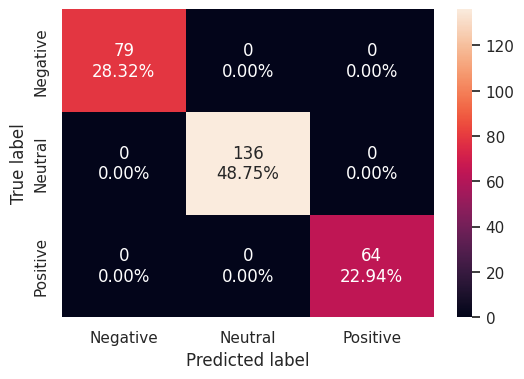

In [131]:
confusion_matrix_sklearn(rf_word2vec_balanced, X_train_word2vec, y_train_word2vec)

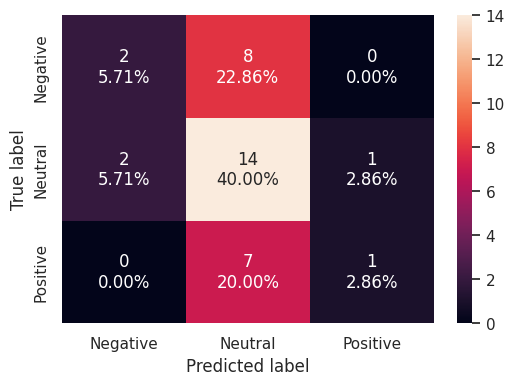

In [132]:
confusion_matrix_sklearn(rf_word2vec_balanced, X_valid_word2vec, y_valid_word2vec)

### Observations:
- Same overfitting observred in case of this Radom forest model as well.
- We did not show classfication report here as it's exactly same as default random forest model with word2vec

### Random Forest (with hyperparameter tuning and Word2Vec)

### We are taking F1_weighted here as metrics as we want both FN and TP to be less .We can not predict sentiment wrongly which might give wrong info for Finiancial analyst to act on.

In [104]:
# Choose the type of classifier
rf_tuned = RandomForestClassifier(class_weight="balanced", random_state=42)

# defining the hyperparameter grid for tuning
parameters = {
    "max_depth": list(np.arange(4, 15, 2)),
    "min_samples_split": [5, 6, 7],
    "n_estimators": np.arange(30, 110, 10),
    "max_features": ["sqrt", "log2"],
}

# defining the type of scoring used to compare parameter combination
# running the grid search
grid_obj = GridSearchCV(rf_tuned, parameters, scoring='f1_weighted', cv=3, n_jobs=-1,error_score='raise',)
grid_obj = grid_obj.fit(X_train_word2vec, y_train_word2vec)

In [105]:
# Creating a new model with the best combination of parameters
rf_word2vec_tuned = grid_obj.best_estimator_

# Fit the new model to the data
rf_word2vec_tuned.fit(X_train_word2vec, y_train_word2vec)

RandomForestClassifier(class_weight='balanced', max_depth=4,
                       max_features='log2', min_samples_split=5,
                       n_estimators=60, random_state=42)

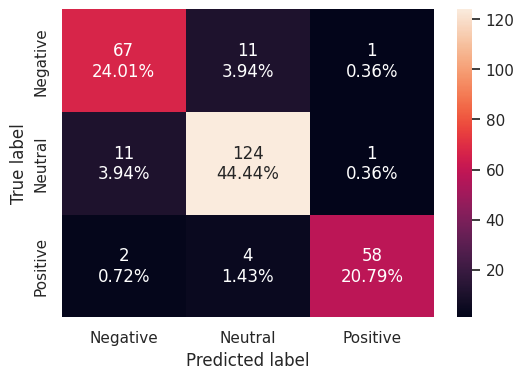

In [106]:
confusion_matrix_sklearn(rf_word2vec_tuned, X_train_word2vec, y_train_word2vec)

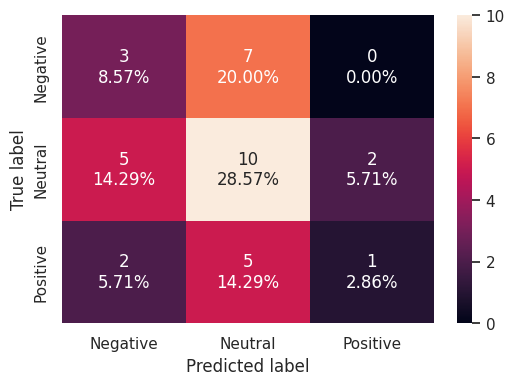

In [107]:
confusion_matrix_sklearn(rf_word2vec_tuned, X_valid_word2vec, y_valid_word2vec)

### Observations:
Though we have reduced the overfitting but still not much improvement in performance

In [112]:
# Predicting on training data
y_pred_train_word2vec_tuned = rf_word2vec_tuned.predict(X_train_word2vec)
# Predicting on validation data
y_pred_valid_word2vec_tuned = rf_word2vec_tuned.predict(X_valid_word2vec)
# Predicting on test data
y_pred_test_word2vec_tuned = rf_word2vec_tuned.predict(X_test_word2vec)

In [113]:
print(classification_report(y_train_word2vec, y_pred_train_word2vec_tuned))

              precision    recall  f1-score   support

    Negative       0.84      0.85      0.84        79
     Neutral       0.89      0.91      0.90       136
    Positive       0.97      0.91      0.94        64

    accuracy                           0.89       279
   macro avg       0.90      0.89      0.89       279
weighted avg       0.89      0.89      0.89       279



In [114]:
print(classification_report(y_valid_word2vec, y_pred_valid_word2vec_tuned))

              precision    recall  f1-score   support

    Negative       0.30      0.30      0.30        10
     Neutral       0.45      0.59      0.51        17
    Positive       0.33      0.12      0.18         8

    accuracy                           0.40        35
   macro avg       0.36      0.34      0.33        35
weighted avg       0.38      0.40      0.38        35



In [115]:
print(classification_report(y_test_word2vec, y_pred_test_word2vec_tuned))

              precision    recall  f1-score   support

    Negative       0.50      0.60      0.55        10
     Neutral       0.50      0.65      0.56        17
    Positive       0.00      0.00      0.00         8

    accuracy                           0.49        35
   macro avg       0.33      0.42      0.37        35
weighted avg       0.39      0.49      0.43        35



### Observations:
- With optimization the peroformmace did not improve that much (Just 1) and even F1 score of neutral  is reduced by 1%

### CatBoost As ML Model

In [122]:
from catboost import CatBoostClassifier

cat_boost_model_word2vec = CatBoostClassifier(
    iterations=200,
    learning_rate=0.1,
    depth=4,
    auto_class_weights='Balanced',
    eval_metric='Accuracy',           # <- single-value metric for best iteration
    custom_metric=['F1'],             # <- this shows F1 per class in logs
    verbose=50,
    random_seed=42)

cat_boost_model_word2vec.fit(X_train_word2vec, y_train_word2vec, eval_set=(X_valid_word2vec, y_valid_word2vec), early_stopping_rounds=20)


0:	learn: 0.4513488	test: 0.4175729	best: 0.4175729 (0)	total: 50.6ms	remaining: 10.1s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.4840274343
bestIteration = 11

Shrink model to first 12 iterations.


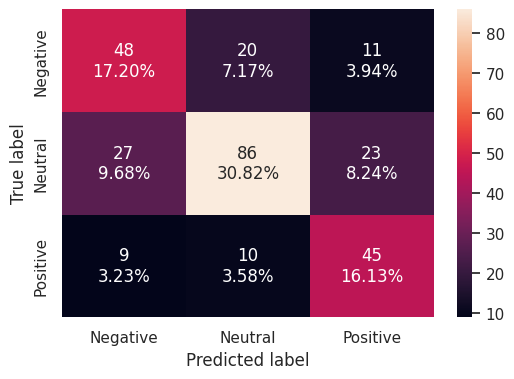

In [123]:
confusion_matrix_sklearn(cat_boost_model_word2vec, X_train_word2vec, y_train_word2vec)

### Observations:
Catboost model did not perform well in training set.For neutral set also it could not detect all the Posive and there are so many are marked as nagative (FN)

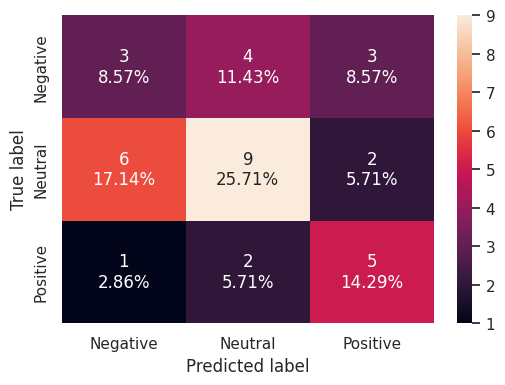

In [124]:
confusion_matrix_sklearn(cat_boost_model_word2vec, X_valid_word2vec, y_valid_word2vec)

### Observations:
Performance bacame worse further and seems likes underfitting with training set.

In [125]:
# Predicting on training  data
y_pred_train_word2vec = cat_boost_model_word2vec.predict(X_train_word2vec)
# Predicting on test data
y_pred_valid_word2vec = cat_boost_model_word2vec.predict(X_valid_word2vec)
# Predicting on test data
y_pred_test_word2vec = cat_boost_model_word2vec.predict(X_test_word2vec)

In [147]:
print(classification_report(y_train_word2vec, y_pred_train_word2vec))

              precision    recall  f1-score   support

    Negative       0.54      0.58      0.56        79
     Neutral       0.70      0.58      0.63       136
    Positive       0.51      0.64      0.57        64

    accuracy                           0.59       279
   macro avg       0.58      0.60      0.59       279
weighted avg       0.61      0.59      0.60       279



In [126]:
print(classification_report(y_valid_word2vec, y_pred_valid_word2vec))

              precision    recall  f1-score   support

    Negative       0.30      0.30      0.30        10
     Neutral       0.60      0.53      0.56        17
    Positive       0.50      0.62      0.56         8

    accuracy                           0.49        35
   macro avg       0.47      0.48      0.47        35
weighted avg       0.49      0.49      0.49        35



In [127]:
print(classification_report(y_test_word2vec, y_pred_test_word2vec))

              precision    recall  f1-score   support

    Negative       0.50      0.70      0.58        10
     Neutral       0.47      0.41      0.44        17
    Positive       0.17      0.12      0.14         8

    accuracy                           0.43        35
   macro avg       0.38      0.41      0.39        35
weighted avg       0.41      0.43      0.41        35



### Observations:
Overall this model perform worser then training set of random forset with word2vec . It seems like it underfit with tranining set. Though we see there are some improvemnets with test score .

**Validation**
Macro F1-score: 0.39
Weighted F1-score: 0.40


**Test**
Macro F1-score: 0.43
Weighted F1-score: 0.45

### Random Forest Model (default with GloVe)

In [150]:
# Building the model
rf_glove = RandomForestClassifier(random_state = 42)

# Fitting on train data
rf_glove.fit(X_train_glove, y_train_glove)

RandomForestClassifier(random_state=42)

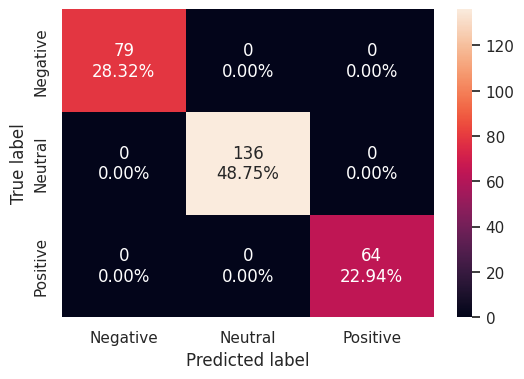

In [151]:
confusion_matrix_sklearn(rf_glove, X_train_glove, y_train_glove)

### Observations:
We can see with training set the model captured everything .This seems to be a overfitting.

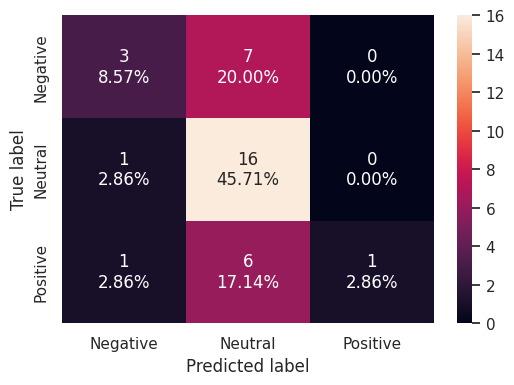

In [152]:
confusion_matrix_sklearn(rf_glove, X_valid_glove, y_valid_glove)

### Observations:
We can see there are around 13 FP in neutral being the dminat class model predicted other class as neutral .Whic has slight decline on randomfirest tuned model in word2vec but still better the default model of word2vec. We will optimise it further.


Classification Report

In [153]:
# Predicting on training  data
y_pred_train_glove = rf_glove.predict(X_train_glove)
# Predicting on test data
y_pred_valid_glove = rf_glove.predict(X_valid_glove)
# Predicting on test data
y_pred_test_glove = rf_glove.predict(X_test_glove)

In [154]:
print(classification_report(y_train_glove, y_pred_train_glove))

              precision    recall  f1-score   support

    Negative       1.00      1.00      1.00        79
     Neutral       1.00      1.00      1.00       136
    Positive       1.00      1.00      1.00        64

    accuracy                           1.00       279
   macro avg       1.00      1.00      1.00       279
weighted avg       1.00      1.00      1.00       279



In [155]:
print(classification_report(y_valid_glove, y_pred_valid_glove))

              precision    recall  f1-score   support

    Negative       0.60      0.30      0.40        10
     Neutral       0.55      0.94      0.70        17
    Positive       1.00      0.12      0.22         8

    accuracy                           0.57        35
   macro avg       0.72      0.46      0.44        35
weighted avg       0.67      0.57      0.50        35



In [156]:
print(classification_report(y_valid_glove, y_pred_test_glove))

              precision    recall  f1-score   support

    Negative       0.50      0.30      0.38        10
     Neutral       0.50      0.82      0.62        17
    Positive       0.00      0.00      0.00         8

    accuracy                           0.49        35
   macro avg       0.33      0.37      0.33        35
weighted avg       0.39      0.49      0.41        35



### Observations:
**Validation :**
- Macro F1-score: 0.44
- Weighted F1-score: 0.50
 This is better then default model of word2vec

**Test :**
- Macro F1-score: 0.33
- Weighted F1-score: 0.41


### Random Forest (with hyperparameter tuning and Glove)

In [169]:
from sklearn.model_selection import StratifiedKFold
# Choose the type of classifier
rf_tuned = RandomForestClassifier(class_weight="balanced", random_state=42)

# defining the hyperparameter grid for tuning
parameters = {
    "max_depth": list(np.arange(4, 15, 2)),
    "max_features": ["sqrt", "log2"],
    "min_samples_split": [5, 6, 7],
    "n_estimators": np.arange(30, 110, 10),
}

# defining the type of scoring used to compare parameter combinations
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
# running the grid search
grid_obj = GridSearchCV(rf_tuned, parameters, scoring='f1_weighted', cv=cv, n_jobs=-1,error_score='raise')
grid_obj = grid_obj.fit(X_train_glove, y_train_glove)

In [170]:
# Creating a new model with the best combination of parameters
rf_glove_tuned = grid_obj.best_estimator_

# Fit the new model to the data
rf_glove_tuned.fit(X_train_glove, y_train_glove)

RandomForestClassifier(class_weight='balanced', max_depth=8,
                       max_features='log2', min_samples_split=7,
                       n_estimators=40, random_state=42)

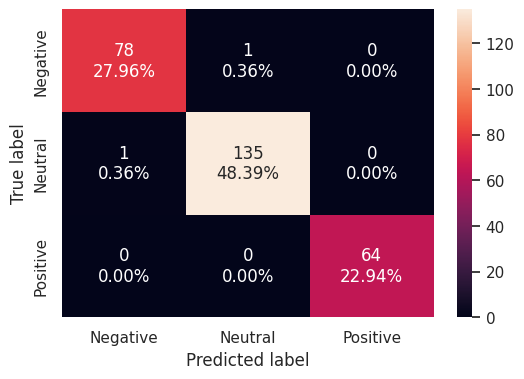

In [171]:
#Printing the confusion matrix
confusion_matrix_sklearn(rf_glove_tuned, X_train_glove, y_train_glove)

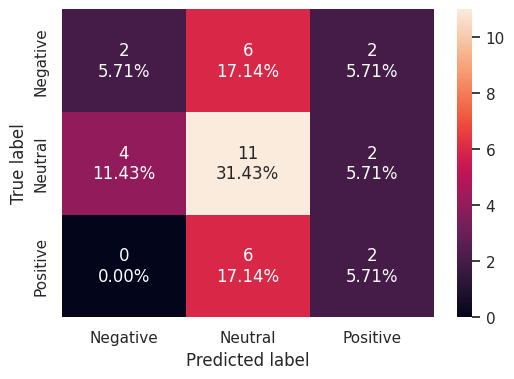

In [172]:
confusion_matrix_sklearn(rf_glove_tuned, X_valid_glove, y_valid_glove)

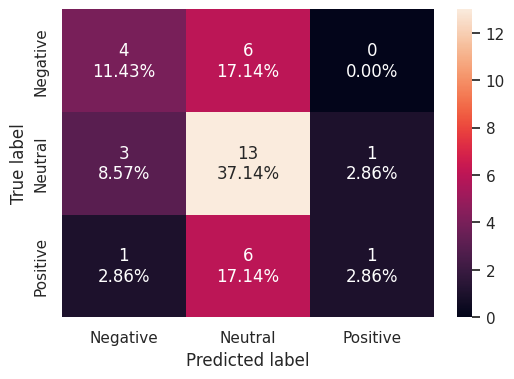

In [173]:
confusion_matrix_sklearn(rf_glove_tuned, X_test_glove, y_test_glove)

### Observations:
- We can see there is not much improvement infact we see TP of neutral case is reduced for validation .Though there are some increase in  TP Positive class but not much

In [174]:
# Predicting on training  data
y_pred_train_glove_tuned = rf_glove_tuned.predict(X_train_glove)
# Predicting on test data
y_pred_valid_glove_tuned = rf_glove_tuned.predict(X_valid_glove)
# Predicting on test data
y_pred_test_glove_tuned = rf_glove_tuned.predict(X_test_glove)

In [175]:
print(classification_report(y_train_glove, y_pred_train_glove_tuned))

              precision    recall  f1-score   support

    Negative       0.99      0.99      0.99        79
     Neutral       0.99      0.99      0.99       136
    Positive       1.00      1.00      1.00        64

    accuracy                           0.99       279
   macro avg       0.99      0.99      0.99       279
weighted avg       0.99      0.99      0.99       279



In [176]:
print(classification_report(y_valid_glove, y_pred_valid_glove_tuned))

              precision    recall  f1-score   support

    Negative       0.33      0.20      0.25        10
     Neutral       0.48      0.65      0.55        17
    Positive       0.33      0.25      0.29         8

    accuracy                           0.43        35
   macro avg       0.38      0.37      0.36        35
weighted avg       0.40      0.43      0.40        35



In [177]:
print(classification_report(y_test_glove, y_pred_test_glove_tuned))

              precision    recall  f1-score   support

    Negative       0.50      0.40      0.44        10
     Neutral       0.52      0.76      0.62        17
    Positive       0.50      0.12      0.20         8

    accuracy                           0.51        35
   macro avg       0.51      0.43      0.42        35
weighted avg       0.51      0.51      0.47        35



### Observations:
**Validation :**
- Macro F1-score: 0.36
- Weighted F1-score: 0.40

**Test :**
- Macro F1-score: 0.42
- Weighted F1-score: 0.47

Not much improvement though there are some increase in test score .


### Sentenece Transformers + ML (Default)

In [178]:
# Building the model
rf_transformer_st = RandomForestClassifier(n_estimators = 100, max_depth = 7, random_state = 42)

# Fitting on train data
rf_transformer_st.fit(X_train_st, y_train_st)

RandomForestClassifier(max_depth=7, random_state=42)

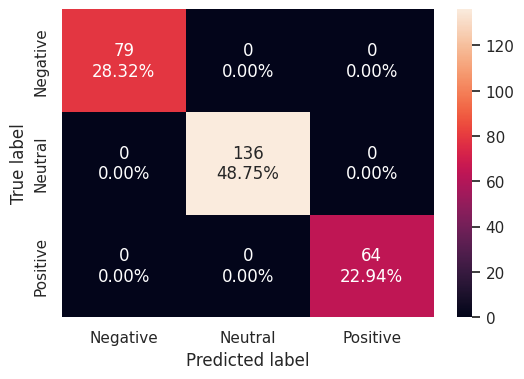

In [179]:
confusion_matrix_sklearn(rf_transformer_st, X_train_st, y_train_st)

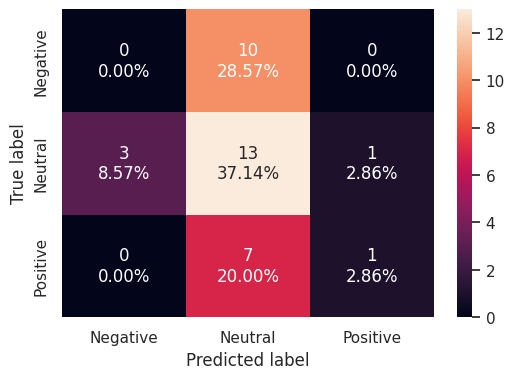

In [180]:
confusion_matrix_sklearn(rf_transformer_st, X_valid_st, y_valid_st)

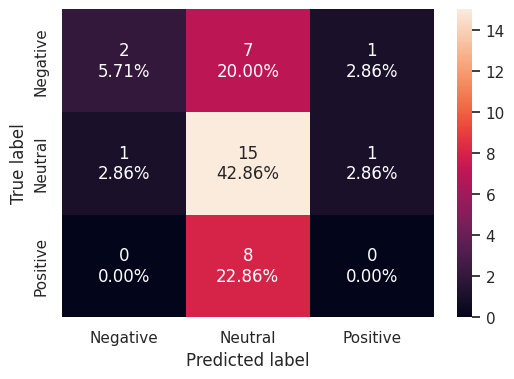

In [181]:
confusion_matrix_sklearn(rf_transformer_st, X_test_st, y_test_st)

### Observations:
Model overfitting and failed to generalise with test and validation set.

In [182]:
# Predicting on training  data
y_pred_train_st = rf_transformer_st.predict(X_train_st)
# Predicting on test data
y_pred_valid_st = rf_transformer_st.predict(X_valid_st)

In [183]:
print(classification_report(y_train_st, y_pred_train_st))

              precision    recall  f1-score   support

    Negative       1.00      1.00      1.00        79
     Neutral       1.00      1.00      1.00       136
    Positive       1.00      1.00      1.00        64

    accuracy                           1.00       279
   macro avg       1.00      1.00      1.00       279
weighted avg       1.00      1.00      1.00       279



In [184]:
print(classification_report(y_valid_st, y_pred_valid_st))

              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00        10
     Neutral       0.43      0.76      0.55        17
    Positive       0.50      0.12      0.20         8

    accuracy                           0.40        35
   macro avg       0.31      0.30      0.25        35
weighted avg       0.32      0.40      0.31        35



### Observations:
**Validation :**
- Macro F1-score: 0.25
- Weighted F1-score: 0.31
We did not do classification report for test set as the performnace of model is quite bad .


### Sentence Transformers + ML (Hyper Parameter Tuning)

### We are taking F1_weighted here as metrics as we want both FN and TP to be less .We can not predict sentiment wrongly which might give wrong info for Finiancial analyst to act on and here both recall and precision is important for for us.

In [185]:
from sklearn.model_selection import StratifiedKFold
# Choose the type of classifier
rf_tuned_st = RandomForestClassifier(class_weight="balanced", random_state=42)

# defining the hyperparameter grid for tuning
parameters = {
    "max_depth": list(np.arange(4, 15, 2)),
    "max_features": ["sqrt", "log2"],
    "min_samples_split": [5, 6, 7],
    "n_estimators": np.arange(30, 110, 10),
}

# defining the type of scoring used to compare parameter combinations
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
# running the grid search
grid_obj = GridSearchCV(rf_tuned, parameters, scoring='f1_weighted', cv=cv, n_jobs=-1,error_score='raise')
grid_obj = grid_obj.fit(X_train_st, y_train_st)

In [186]:
# Creating a new model with the best combination of parameters
rf_st_tuned = grid_obj.best_estimator_

# Fit the new model to the data
rf_st_tuned.fit(X_train_st, y_train_st)

RandomForestClassifier(class_weight='balanced', max_depth=4,
                       min_samples_split=7, n_estimators=30, random_state=42)

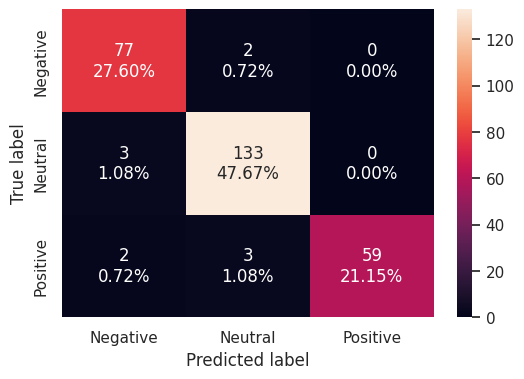

In [187]:
confusion_matrix_sklearn(rf_st_tuned, X_train_st, y_train_st)

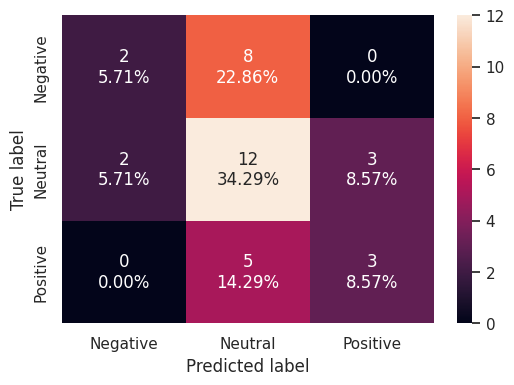

In [188]:
confusion_matrix_sklearn(rf_st_tuned, X_valid_st, y_valid_st)

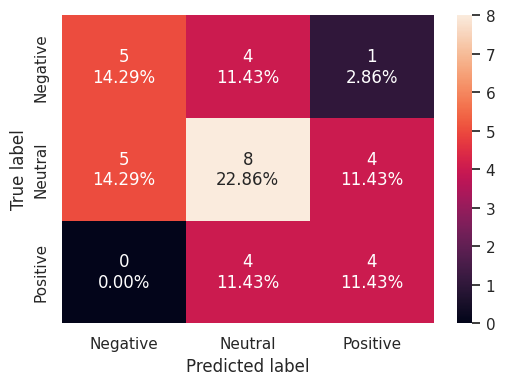

In [190]:
confusion_matrix_sklearn(rf_st_tuned, X_test_st, y_test_st)

### Observations:
 - We can see there are some increase in True Postive of other classes like "Postive" class in both test and validation set
 - Though we can see there is less TP for neutral class almost reduced by half for test set inc compariosn to glove tuned and sentence transformer default model.

In [193]:
# Predicting on training  data
y_pred_train_st_tuned = rf_st_tuned.predict(X_train_st)
# Predicting on validation data
y_pred_valid_st_tuned = rf_st_tuned.predict(X_valid_st)
# Predicting on test data
y_pred_test_st_tuned = rf_st_tuned.predict(X_test_st)

In [194]:
print(classification_report(y_train_st, y_pred_train_st_tuned))

              precision    recall  f1-score   support

    Negative       0.94      0.97      0.96        79
     Neutral       0.96      0.98      0.97       136
    Positive       1.00      0.92      0.96        64

    accuracy                           0.96       279
   macro avg       0.97      0.96      0.96       279
weighted avg       0.97      0.96      0.96       279



In [195]:
print(classification_report(y_valid_st, y_pred_valid_st_tuned))

              precision    recall  f1-score   support

    Negative       0.50      0.20      0.29        10
     Neutral       0.48      0.71      0.57        17
    Positive       0.50      0.38      0.43         8

    accuracy                           0.49        35
   macro avg       0.49      0.43      0.43        35
weighted avg       0.49      0.49      0.46        35



In [196]:
print(classification_report(y_test_st, y_pred_test_st_tuned))

              precision    recall  f1-score   support

    Negative       0.50      0.50      0.50        10
     Neutral       0.50      0.47      0.48        17
    Positive       0.44      0.50      0.47         8

    accuracy                           0.49        35
   macro avg       0.48      0.49      0.49        35
weighted avg       0.49      0.49      0.49        35



### Observations:
**Validation :**
- Macro F1-score: 0.43
- Weighted F1-score: 0.346

**Test :**
- Macro F1-score: 0.49
- Weighted F1-score: 0.49
This model still not good but better then other word 2 vec tuned and glove tuned model.


## Model Selection
#Model Performance Summary

### Models Compared:

-  Word2Vec + RandomForest (tuned)
-  CatBoost Word2vec
-  GloVe + RandomForest (tuned)
-  Sentence Transformer + RandomForest (tuned)

---
## Word2Vec + RandomForest (tuned)

## Train Set
| Class     | Precision | Recall | F1-Score |
|-----------|-----------|--------|----------|
| Negative  | 0.84      | 0.85   | 0.84     |
| Neutral   | 0.89      | 0.91   | 0.90     |
| Positive  | 0.97      | 0.91   | 0.94     |
| **Accuracy**       |         |        | **0.89**   |
| **Macro Avg**      | 0.90    | 0.89   | 0.89     |
| **Weighted Avg**   | 0.89    | 0.89   | 0.89     |

---

## Validation Set
| Class     | Precision | Recall | F1-Score |
|-----------|-----------|--------|----------|
| Negative  | 0.30      | 0.30   | 0.30     |
| Neutral   | 0.45      | 0.59   | 0.51     |
| Positive  | 0.33      | 0.12   | 0.18     |
| **Accuracy**       |         |        | **0.40**   |
| **Macro Avg**      | 0.36    | 0.34   | 0.33     |
| **Weighted Avg**   | 0.38    | 0.40   | 0.38     |

---

## Test Set
| Class     | Precision | Recall | F1-Score |
|-----------|-----------|--------|----------|
| Negative  | 0.50      | 0.60   | 0.55     |
| Neutral   | 0.50      | 0.65   | 0.56     |
| Positive  | 0.00      | 0.00   | 0.00     |
| **Accuracy**       |         |        | **0.49**   |
| **Macro Avg**      | 0.33    | 0.42   | 0.37     |
| **Weighted Avg**   | 0.39    | 0.49   | 0.43     |

---


## Word2Vec + CatBoost

### **Train Set**
| Class     | Precision | Recall | F1-Score |
|-----------|-----------|--------|----------|
| Negative  | 0.54      | 0.58   | 0.56     |
| Neutral   | 0.70      | 0.58   | 0.63     |
| Positive  | 0.51      | 0.64   | 0.57     |
| **Accuracy**       |       |        | **0.59**   |
| **Macro Avg**      | 0.58  | 0.60   | 0.59     |
| **Weighted Avg**   | 0.61  | 0.59   | 0.60     |

---

### **Validation Set**
| Class     | Precision | Recall | F1-Score |
|-----------|-----------|--------|----------|
| Negative  | 0.30      | 0.30   | 0.30     |
| Neutral   | 0.60      | 0.35   | 0.44     |
| Positive  | 0.33      | 0.62   | 0.43     |
| **Accuracy**       |       |        | **0.40**   |
| **Macro Avg**      | 0.41  | 0.43   | 0.39     |
| **Weighted Avg**   | 0.45  | 0.40   | 0.40     |

---

### **Test Set**
| Class     | Precision | Recall | F1-Score |
|-----------|-----------|--------|----------|
| Negative  | 0.43      | 0.60   | 0.50     |
| Neutral   | 0.57      | 0.47   | 0.52     |
| Positive  | 0.29      | 0.25   | 0.27     |
| **Accuracy**       |       |        | **0.46**|
| **Macro Avg**      | 0.43  | 0.44   | 0.43     |
| **Weighted Avg**   | 0.47  | 0.46   | 0.45     |

---

##  GloVe + RandomForest (Tuned)
### **Train Set**
| Class     | Precision | Recall | F1-score |
|-----------|-----------|--------|----------|
| Negative  | 0.99      | 0.99   | 0.99     |
| Neutral   | 0.99      | 0.99   | 0.99     |
| Positive  | 1.00      | 1.00   | 1.00     |
| **Accuracy**     |       |        | **0.99**  |
| **Macro Avg**    | 0.99  | 0.99   | 0.99     |
| **Weighted Avg** | 0.99  | 0.99   | 0.99     |


---

### **Validation Set**
| Class     | Precision | Recall | F1-score |
|-----------|-----------|--------|----------|
| Negative  | 0.33      | 0.20   | 0.25     |
| Neutral   | 0.48      | 0.65   | 0.55     |
| Positive  | 0.33      | 0.25   | 0.29     |
| **Accuracy**     |       |        | **0.43**  |
| **Macro Avg**    | 0.38  | 0.37   | 0.36     |
| **Weighted Avg** | 0.40  | 0.43   | 0.40     |


---

### **Test Set**
| Class     | Precision | Recall | F1-score |
|-----------|-----------|--------|----------|
| Negative  | 0.50      | 0.40   | 0.44     |
| Neutral   | 0.52      | 0.76   | 0.62     |
| Positive  | 0.50      | 0.12   | 0.20     |
| **Accuracy**     |       |        | **0.51**  |
| **Macro Avg**    | 0.51  | 0.43   | 0.42     |
| **Weighted Avg** | 0.51  | 0.51   | 0.47     |


---

### Sentence Transformer + RandomForest (Tuned)
### **Train Set**
| Class     | Precision | Recall | F1-score |
|-----------|-----------|--------|----------|
| Negative  | 0.94      | 0.97   | 0.96     |
| Neutral   | 0.96      | 0.98   | 0.97     |
| Positive  | 1.00      | 0.92   | 0.96     |
| **Accuracy** |         |        | **0.96**  |
| **Macro Avg** | 0.97  | 0.96   | 0.96     |
| **Weighted Avg** | 0.97 | 0.96 | 0.96     |

---

### **Validation Set**
| Class     | Precision | Recall | F1-score |
|-----------|-----------|--------|----------|
| Negative  | 0.50      | 0.20   | 0.29     |
| Neutral   | 0.48      | 0.71   | 0.57     |
| Positive  | 0.50      | 0.38   | 0.43     |
| **Accuracy** |         |        | **0.49**  |
| **Macro Avg** | 0.49  | 0.43   | 0.43     |
| **Weighted Avg** | 0.49 | 0.49 | 0.46     |


---

### **Test Set**
| Class     | Precision | Recall | F1-score |
|-----------|-----------|--------|----------|
| Negative  | 0.50      | 0.50   | 0.50     |
| Neutral   | 0.50      | 0.47   | 0.48     |
| Positive  | 0.44      | 0.50   | 0.47     |
| **Accuracy** |         |        | **0.49**  |
| **Macro Avg** | 0.48  | 0.49   | 0.49     |
| **Weighted Avg** | 0.49 | 0.49 | 0.49     |

---

### Notes
- Performance on the train set shows reasonable learning.
- Drop in performance on validation/test suggests potential **overfitting**.



---
 - All model struggle with overfitting and catboost struggle with underfit
 - Word2vec with Random forest struggle with Poor generalization to validation/test sets, especially for the `Positive` class.
- `Positive` class has **zero predictive power** in the test set for word2vec tuned model with random forest

We see best performnace with **Sentence Transformer + RF Tuned** model with F1 score weighted avg is .49 and even **GLoVe + RF Tuned** has weighted avg of F1 score of .51







# **Weekly News Summarization**

**Important Note**: It is recommended to run this section of the project independently from the previous sections in order to avoid runtime crashes due to RAM overload.

#### Installing and Importing the necessary libraries